In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
import pandas as pd
import re
import lhapdf

plt.rcParams.update({
    "text.usetex": True,           # Use LaTeX for all text
    "font.family": "serif",        # Use a specific font family
    "text.latex.preamble": r"\usepackage{amsmath, amssymb, bm}",  # Load additional packages
})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 16

# Checking Hessian compression

In [45]:
# Define the PDF sets
pdf_sets = {
    "baseline": lhapdf.getPDFSet("PDF4EFT_baseline_noHMDY"),
    #"h_40": lhapdf.getPDFSet("PDF4EFT_baseline_noHMDY_40"),
    "h_80": lhapdf.getPDFSet("PDF4EFT_baseline_noHMDY_80")
}

In [46]:
# Define values for x and Q
Q = 10.0  # Factorisation scale in GeV

x_min = 1e-3
x_max = 0.5
xs = np.logspace(np.log10(x_min), np.log10(x_max), 200)

#z_min_bff = -2
#z_max_bff = 0
#zs = np.logspace(z_min_bff, z_max_bff, 1000)

# Define PDG IDs for flavors
flavors = {
    "u": 2,
    "ubar": -2,
    "d": 1,
    "dbar": -1,
    "s": 3,
    "sbar": -3,
    "c": 4,
    "cbar": -4,
    "g": 21,
}

In [47]:
# Store central values and uncertainties for all flavors
central_values = {flavor: {} for flavor in flavors}
uncertainties = {flavor: {} for flavor in flavors}

# Loop over each PDF set to extract data
for set_name, pdf_set in pdf_sets.items():
    # Generate PDF members
    pdf_members = pdf_set.mkPDFs()
    
    # Loop over flavors
    for flavor, pid in flavors.items():
        # Extract central values and uncertainties for the flavor
        xf_all = np.array([[pdf.xfxQ(pid, x, Q) for pdf in pdf_members] for x in xs])  # All members for each z

        #if set_name == "PDF4LHC21_900":
            ## Exclude the '0' member for the average
            #central = np.mean(xuAll[:, 1:], axis=1)
        #else:
            ## Use the '0' member as central
            #central = xuAll[:, 0]

        central = xf_all[:, 0]

        # Compute uncertainties
        err_plus = np.zeros_like(xs)
        err_minus = np.zeros_like(xs)

        for i, x in enumerate(xs):
            #err = pdf_set.uncertainty(xf_all[i], 68)  # Compute uncertainty for each z
            err = pdf_set.uncertainty(xf_all[i])  # Compute uncertainty for each z
            err_plus[i] = err.errplus
            err_minus[i] = err.errminus
        
        # Store values
        central_values[flavor][set_name] = central
        uncertainties[flavor][set_name] = (err_plus, err_minus)



LHAPDF 6.5.4 loading all 109 PDFs in set PDF4EFT_baseline_noHMDY
PDF4EFT_baseline_noHMDY, version 1; 109 PDF members
LHAPDF 6.5.4 loading all 81 PDFs in set PDF4EFT_baseline_noHMDY_80
PDF4EFT_baseline_noHMDY_80, version 1; 81 PDF members


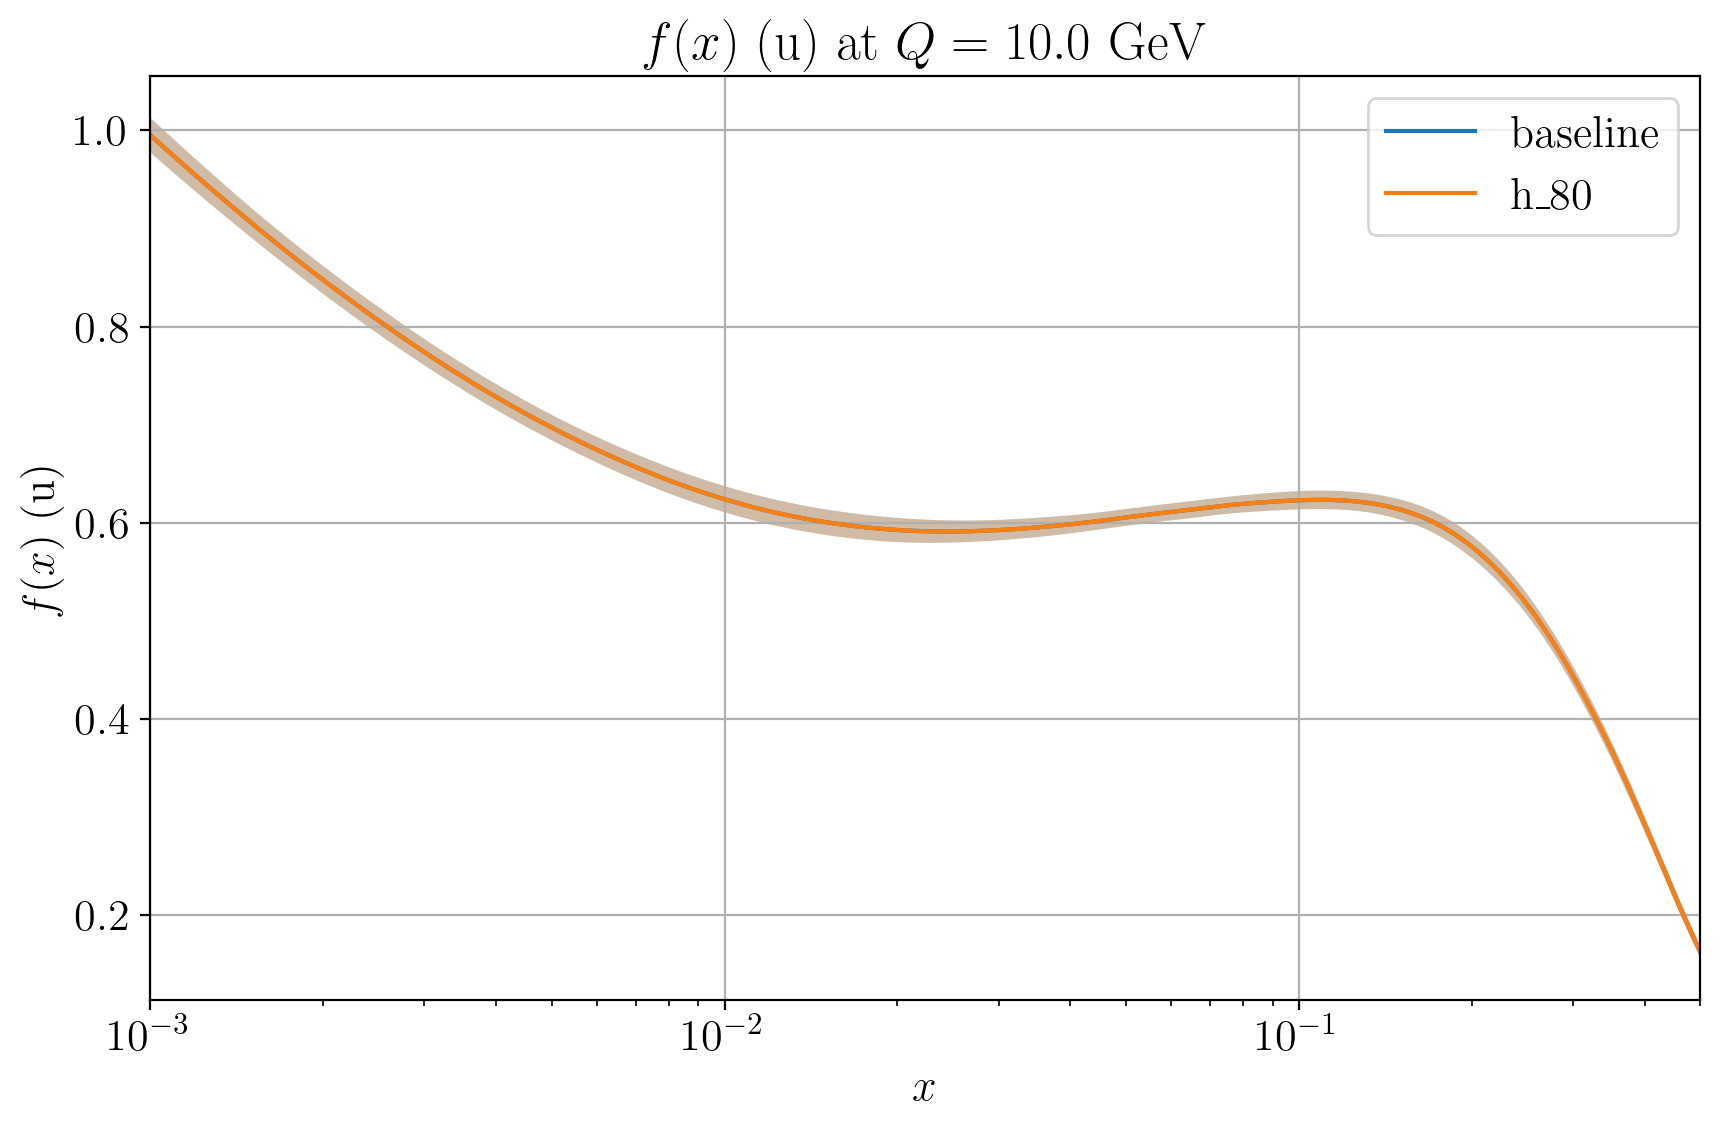

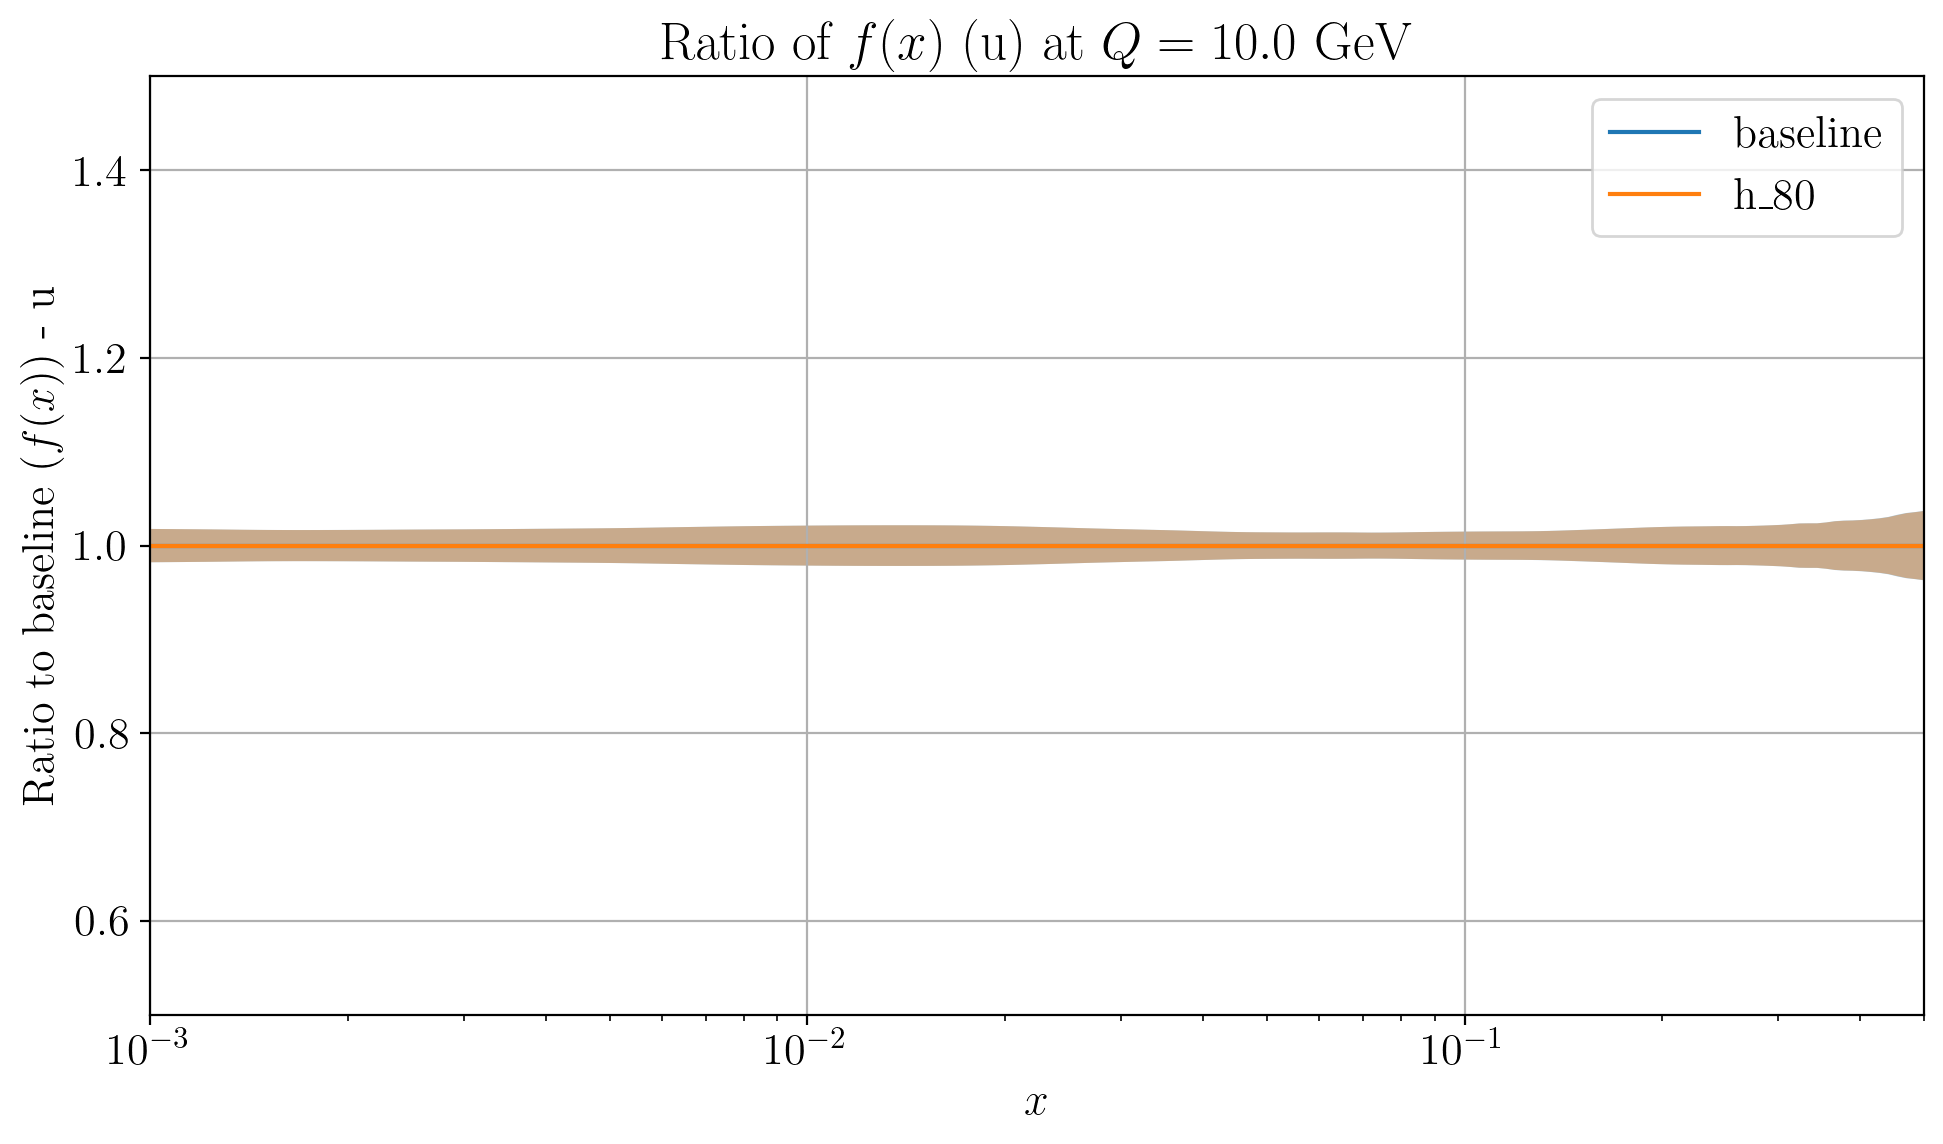

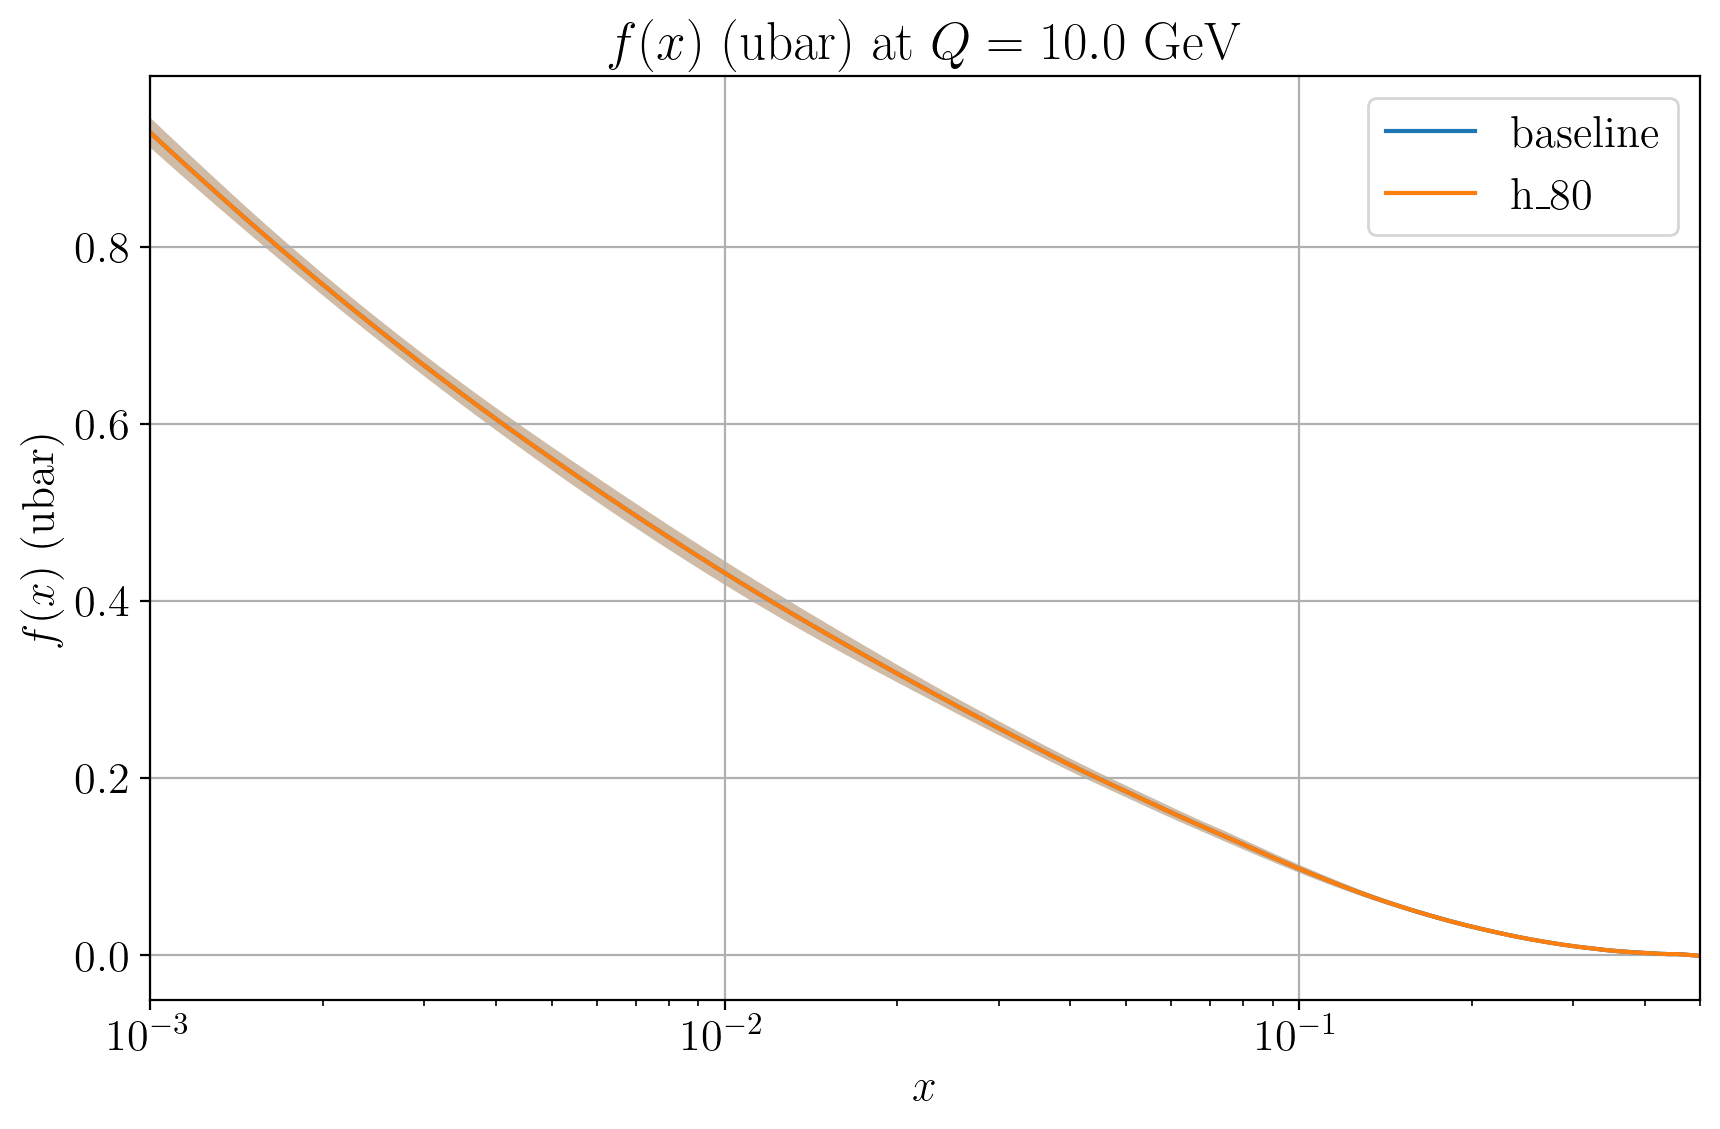

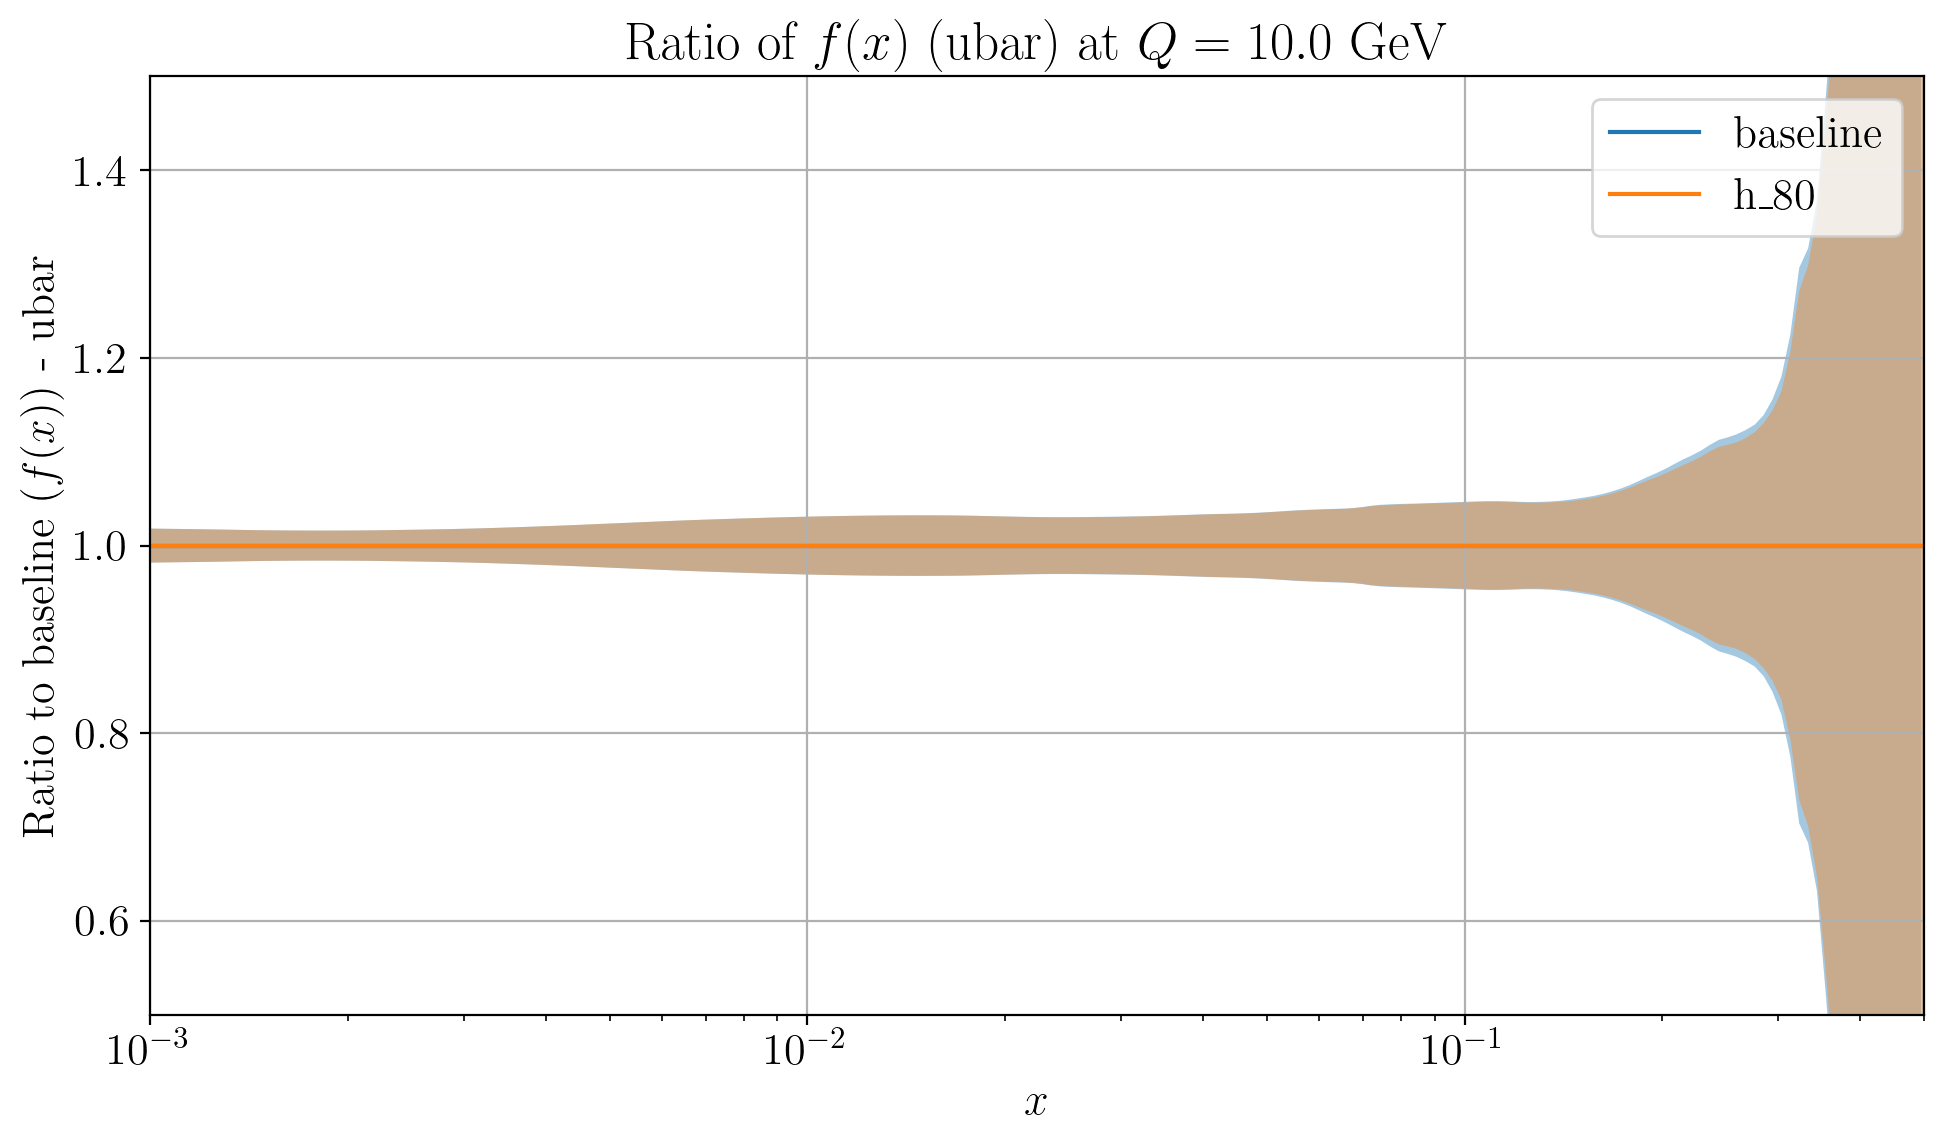

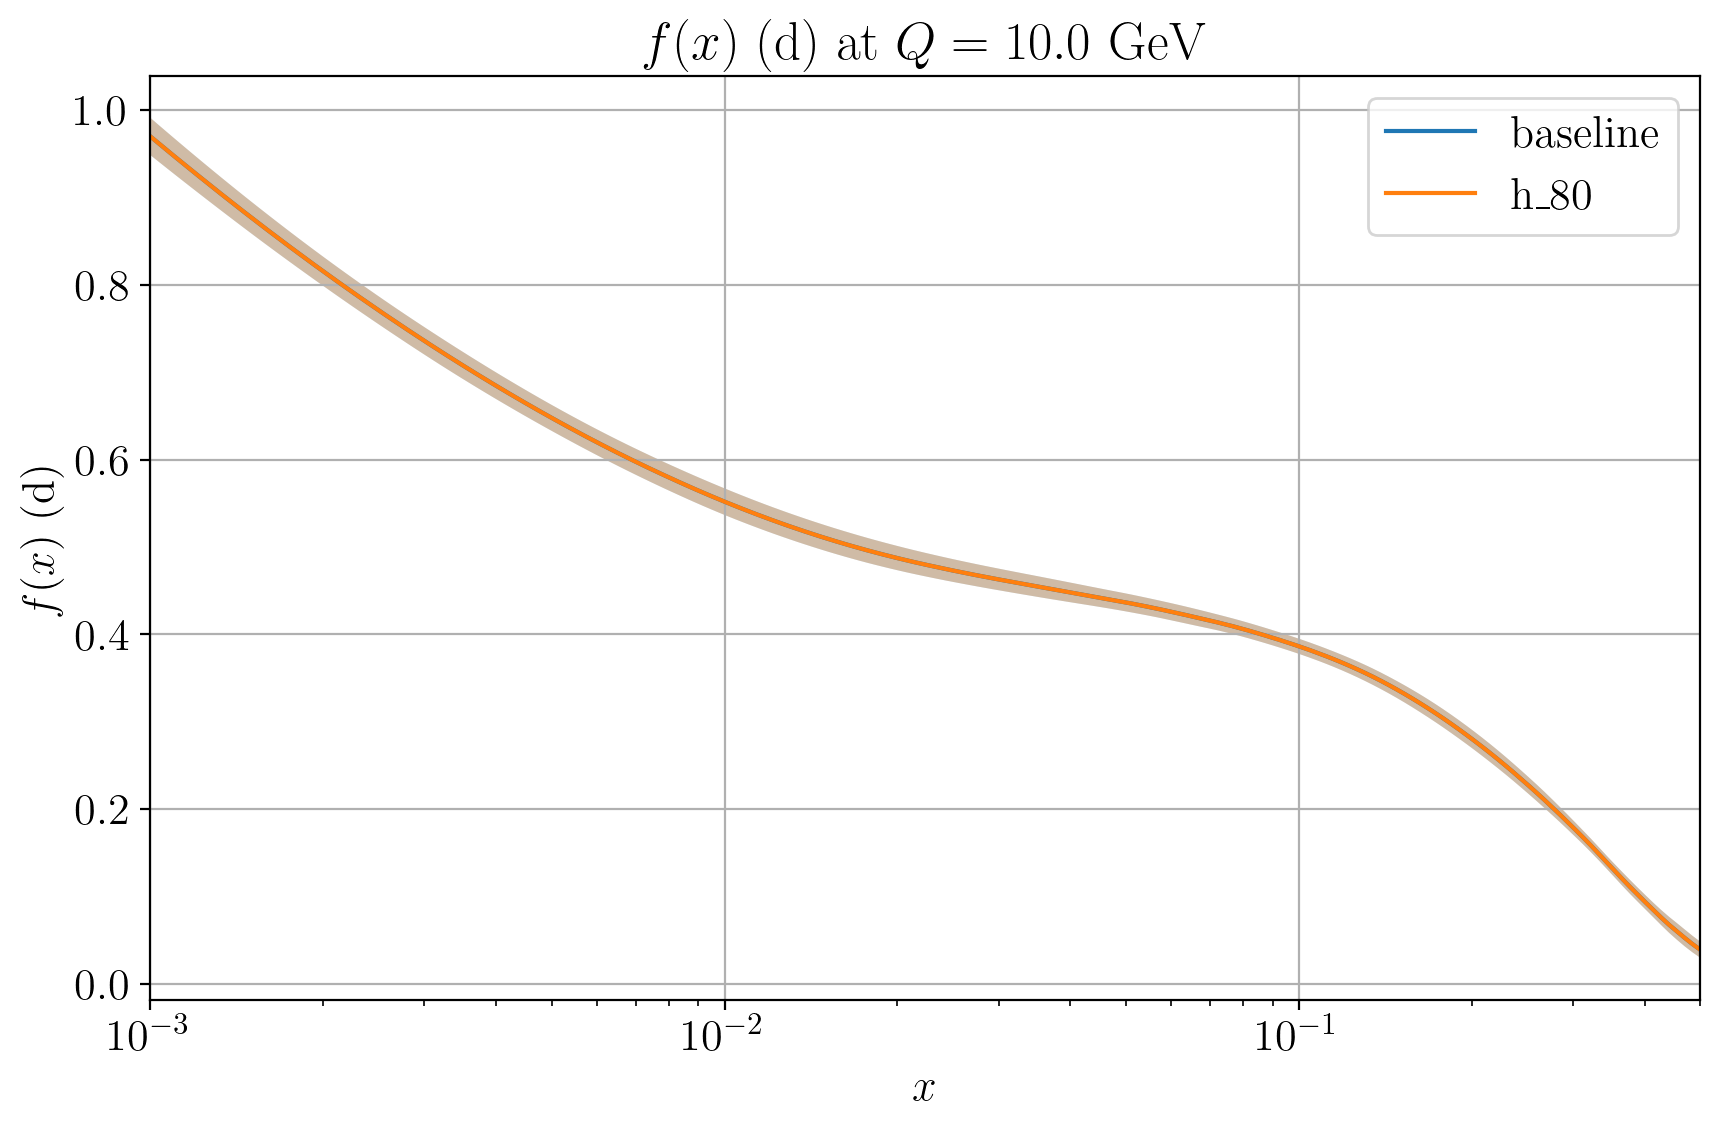

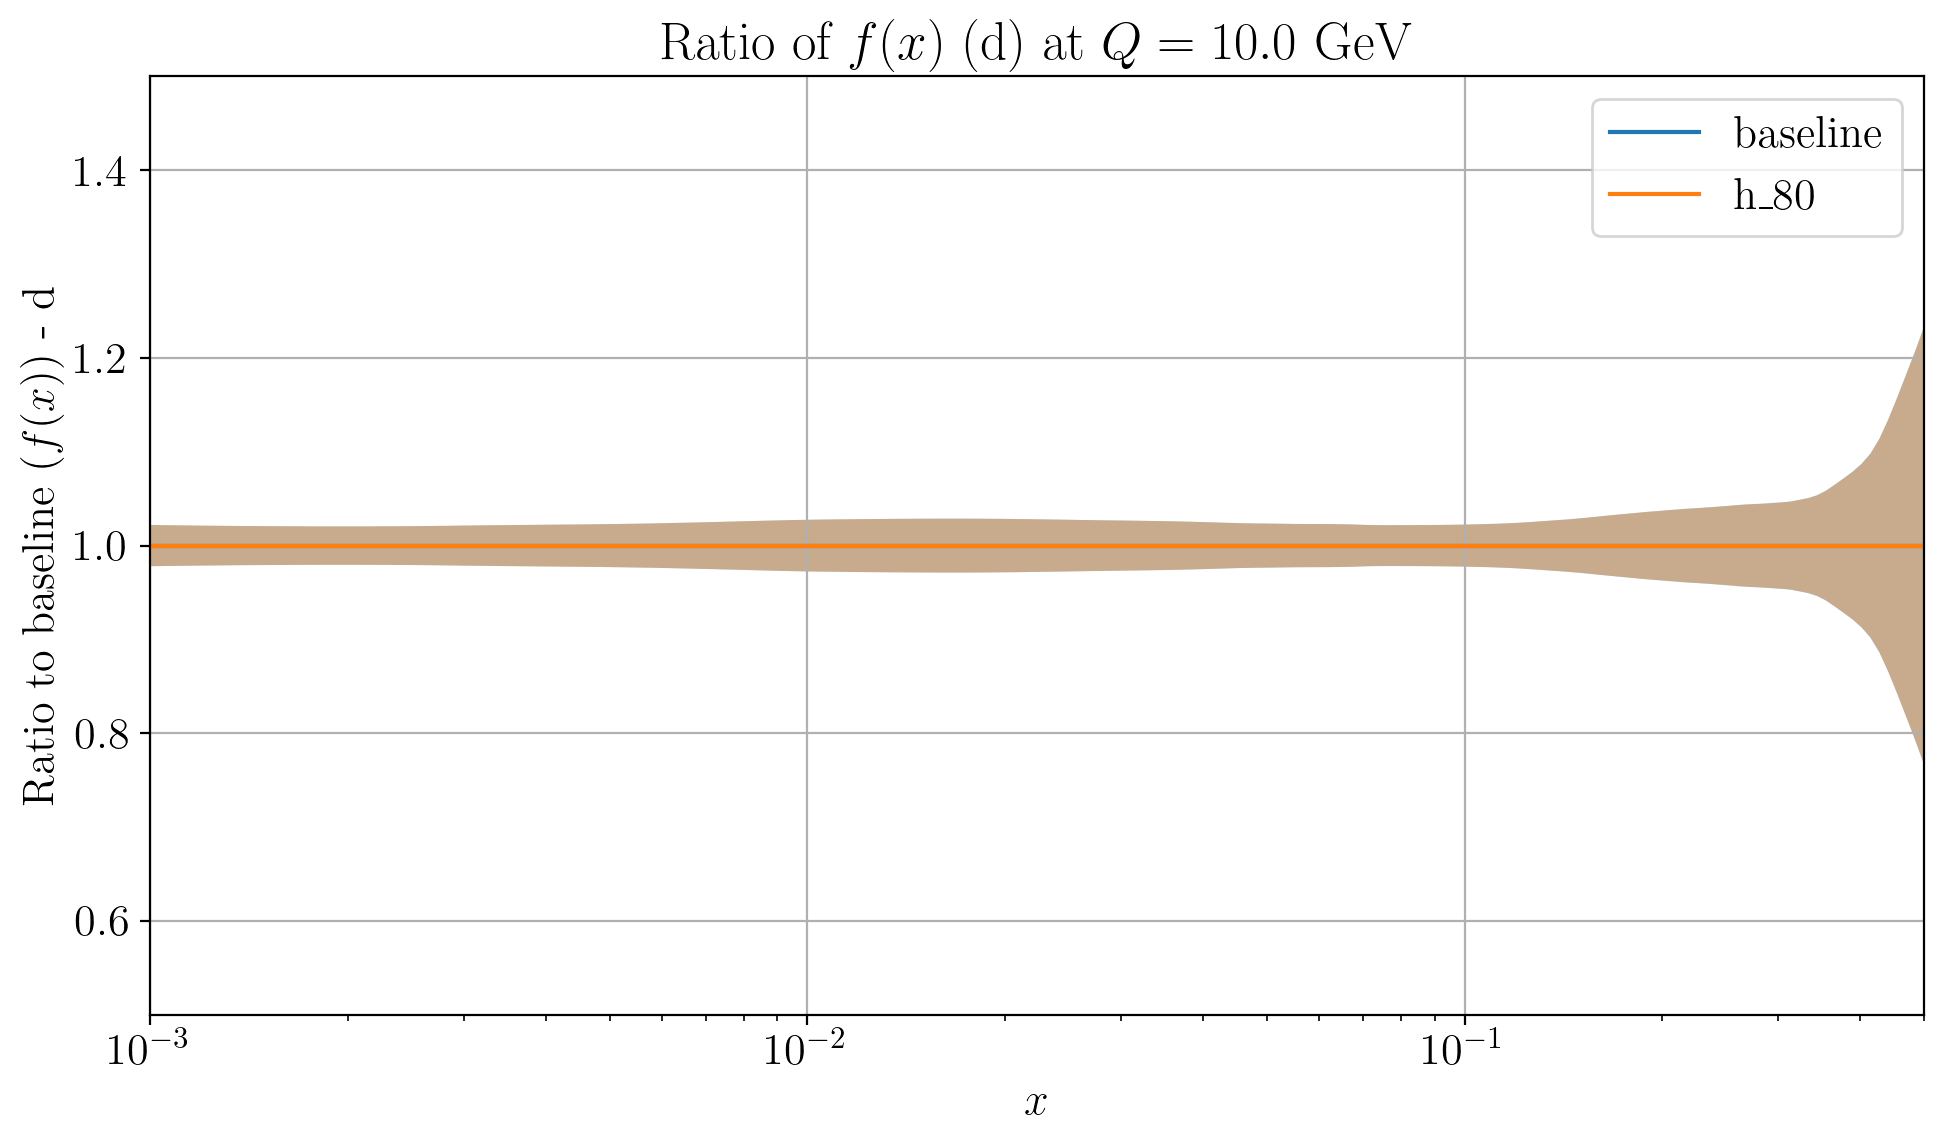

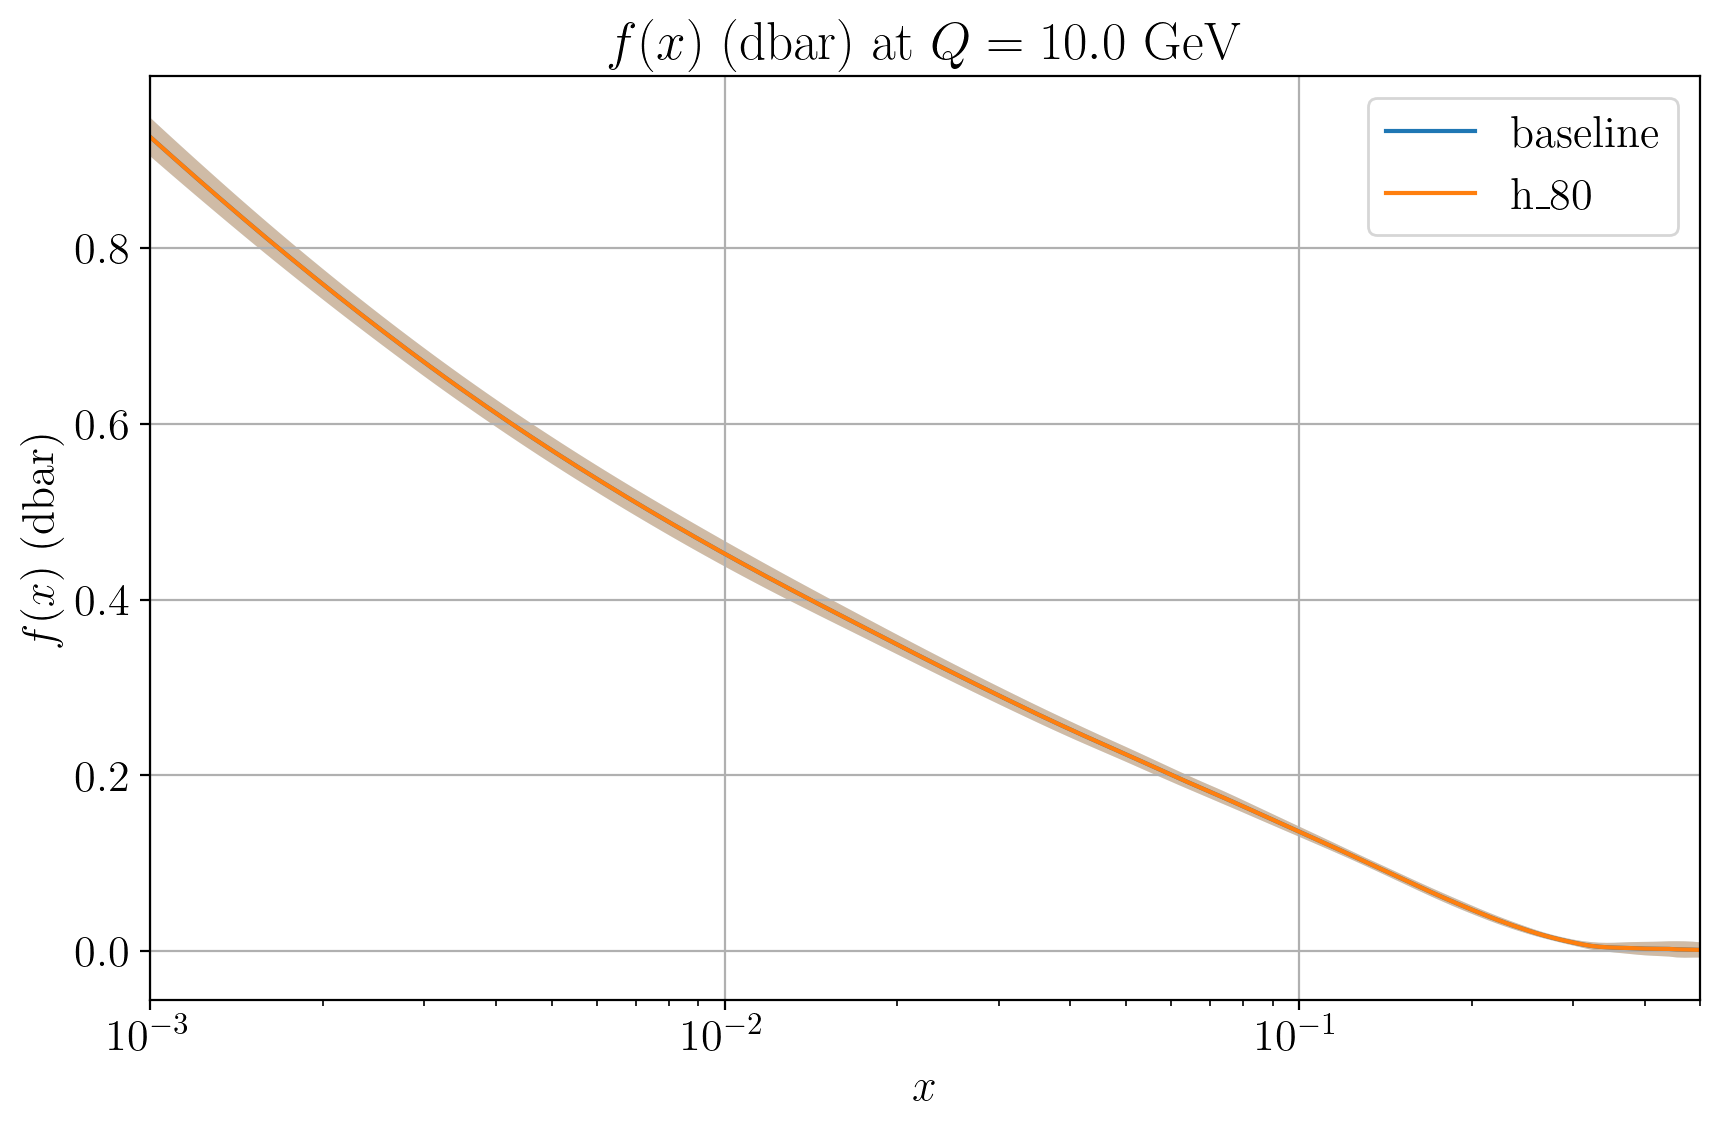

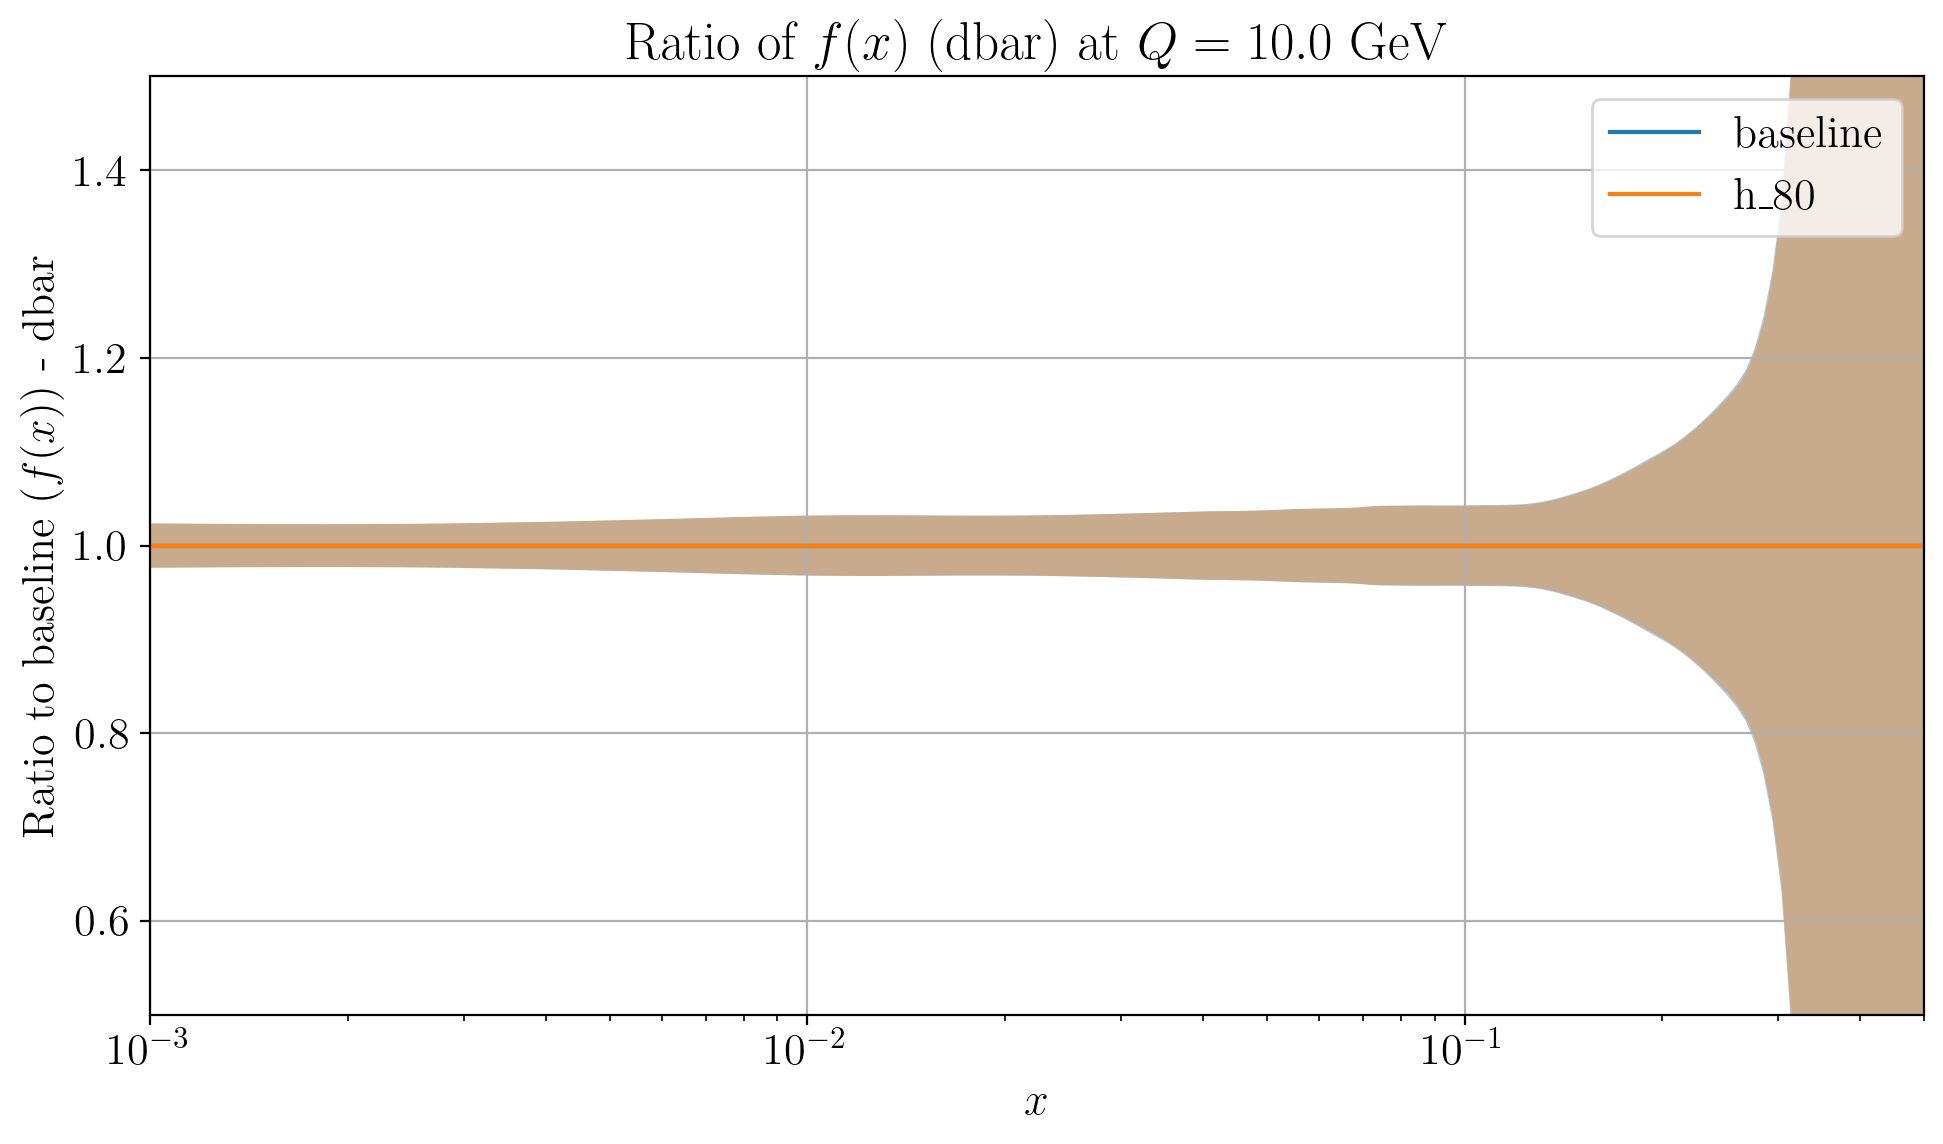

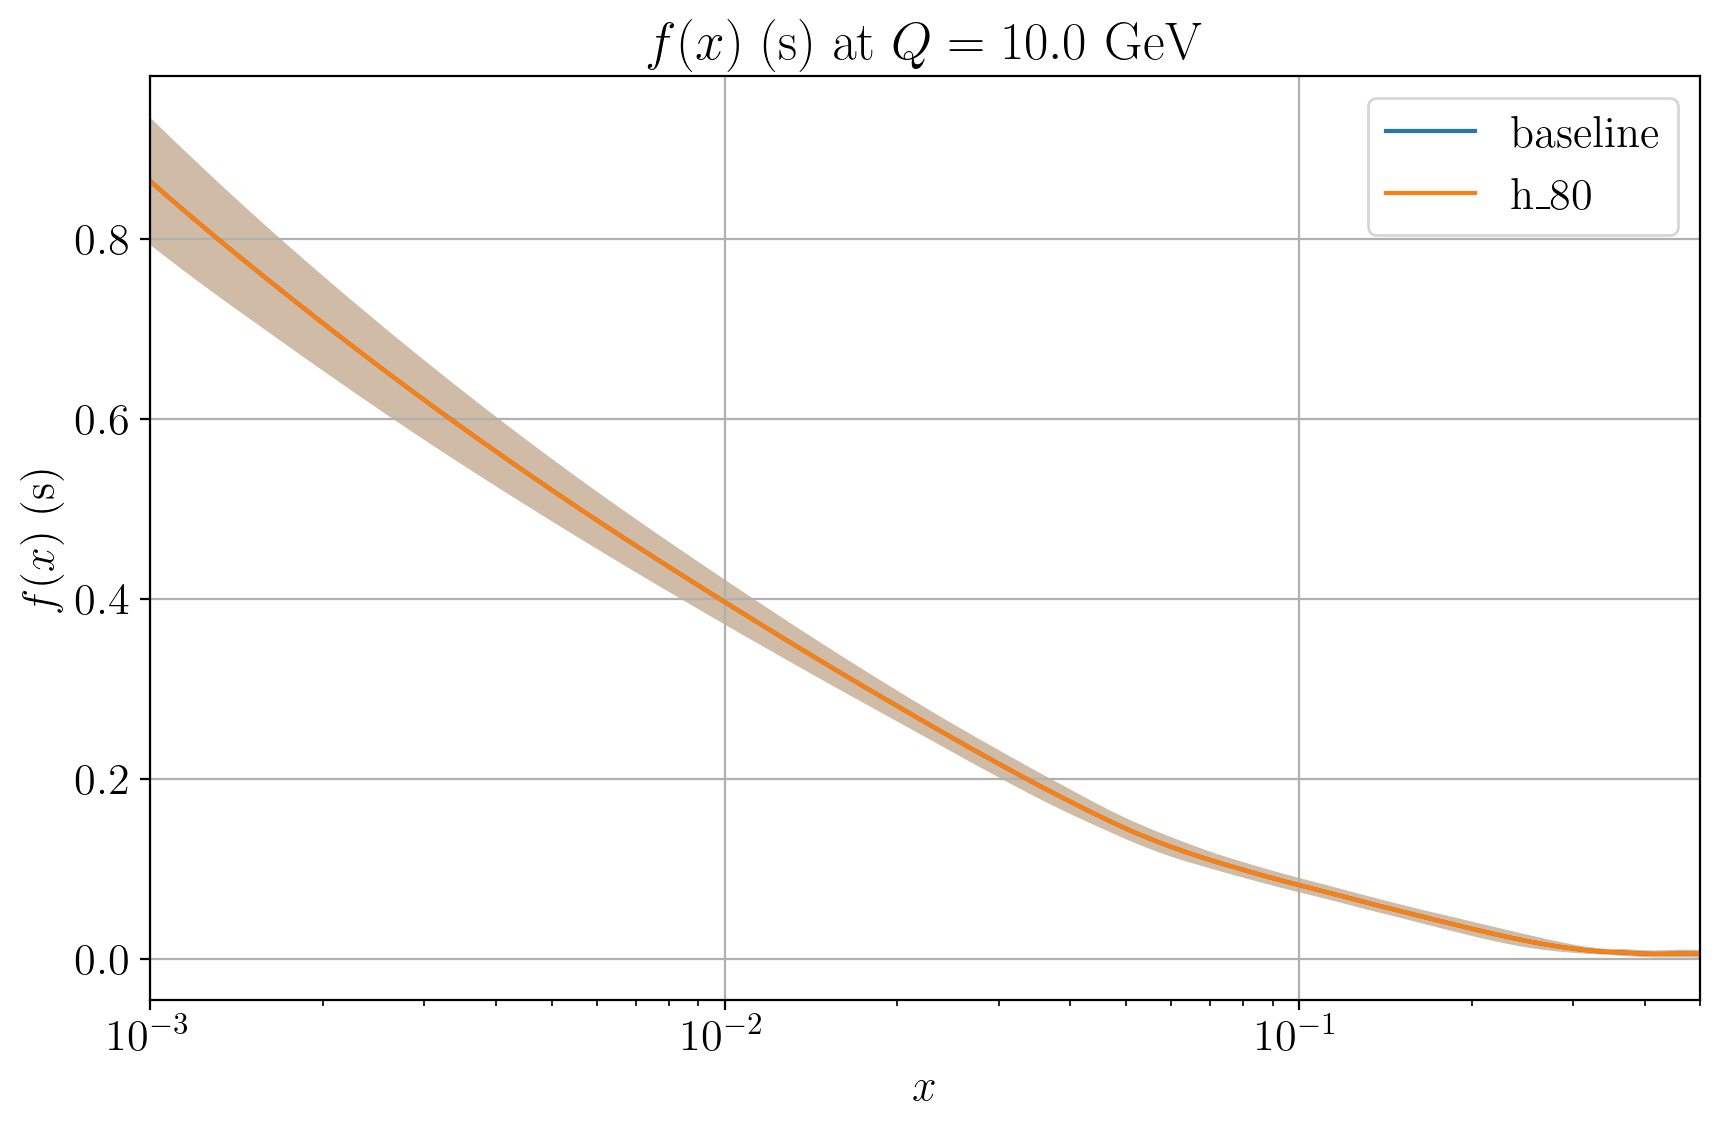

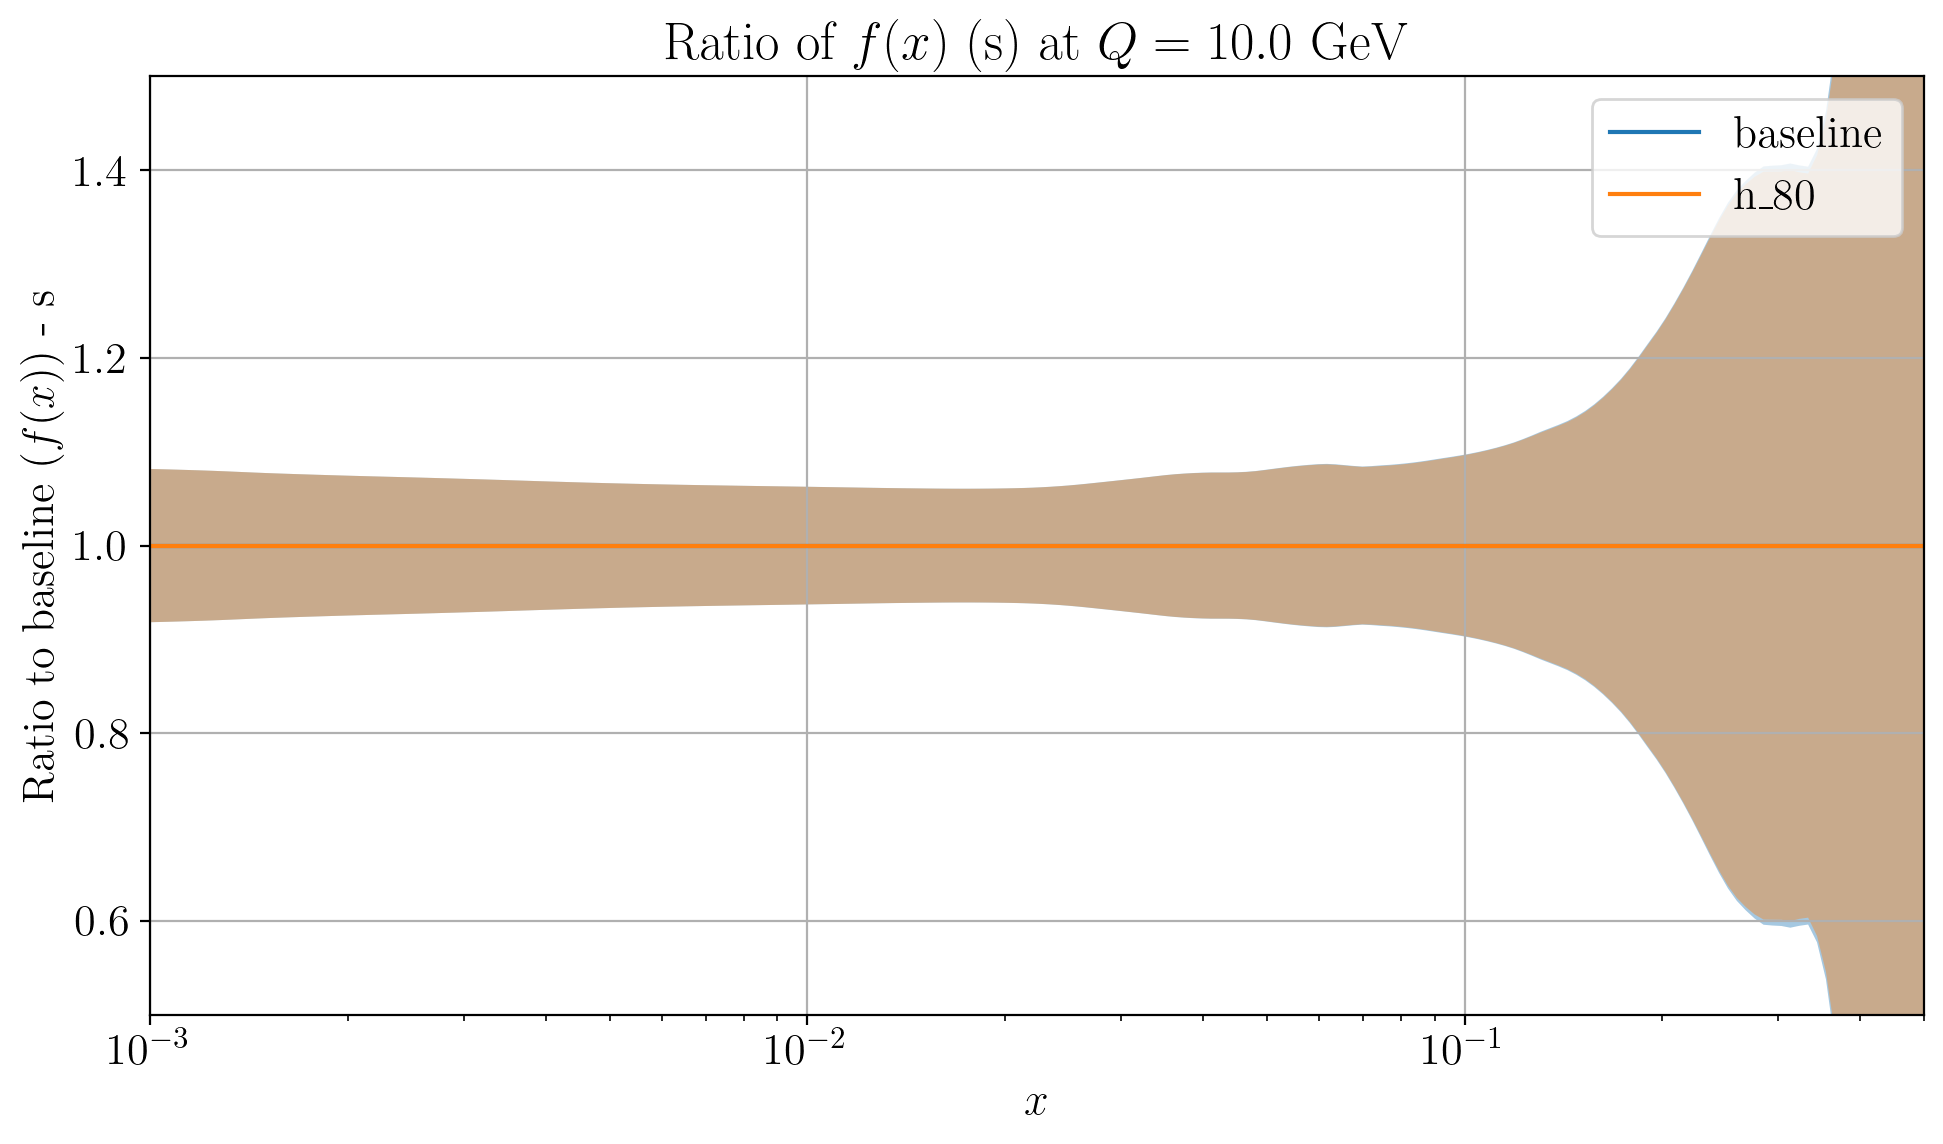

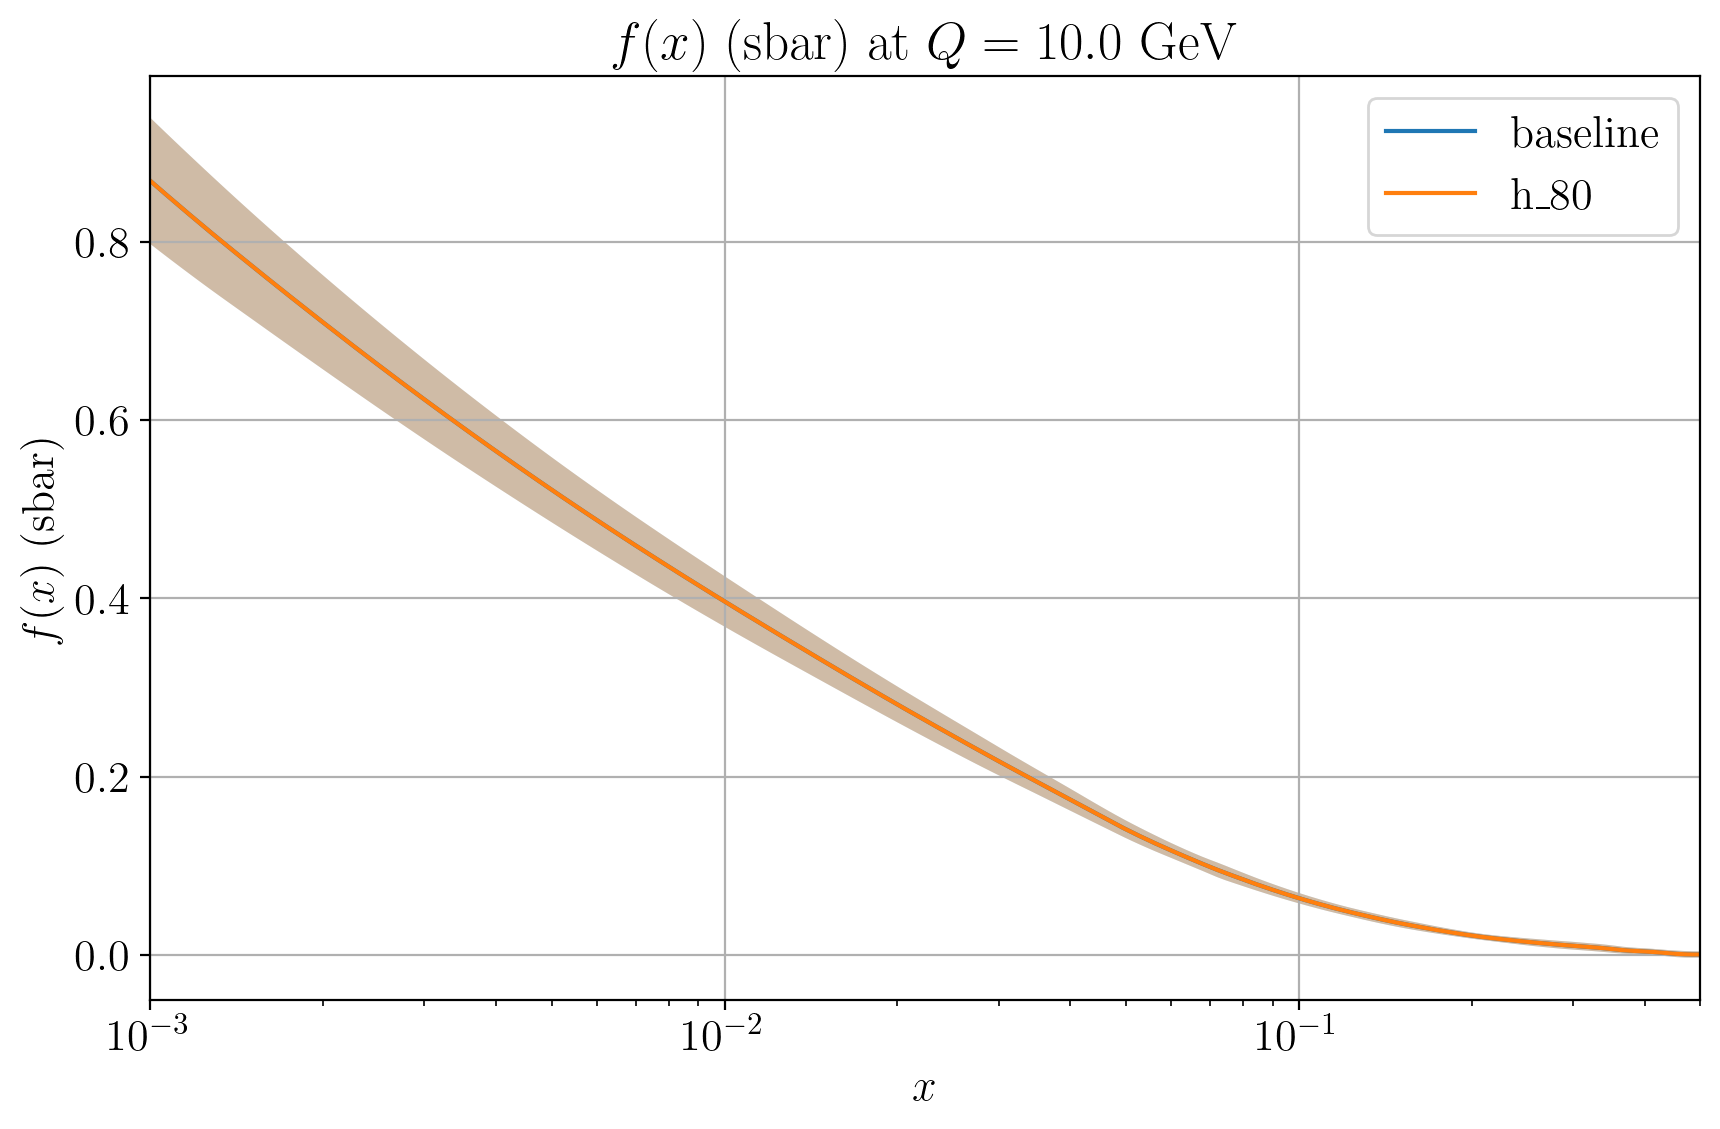

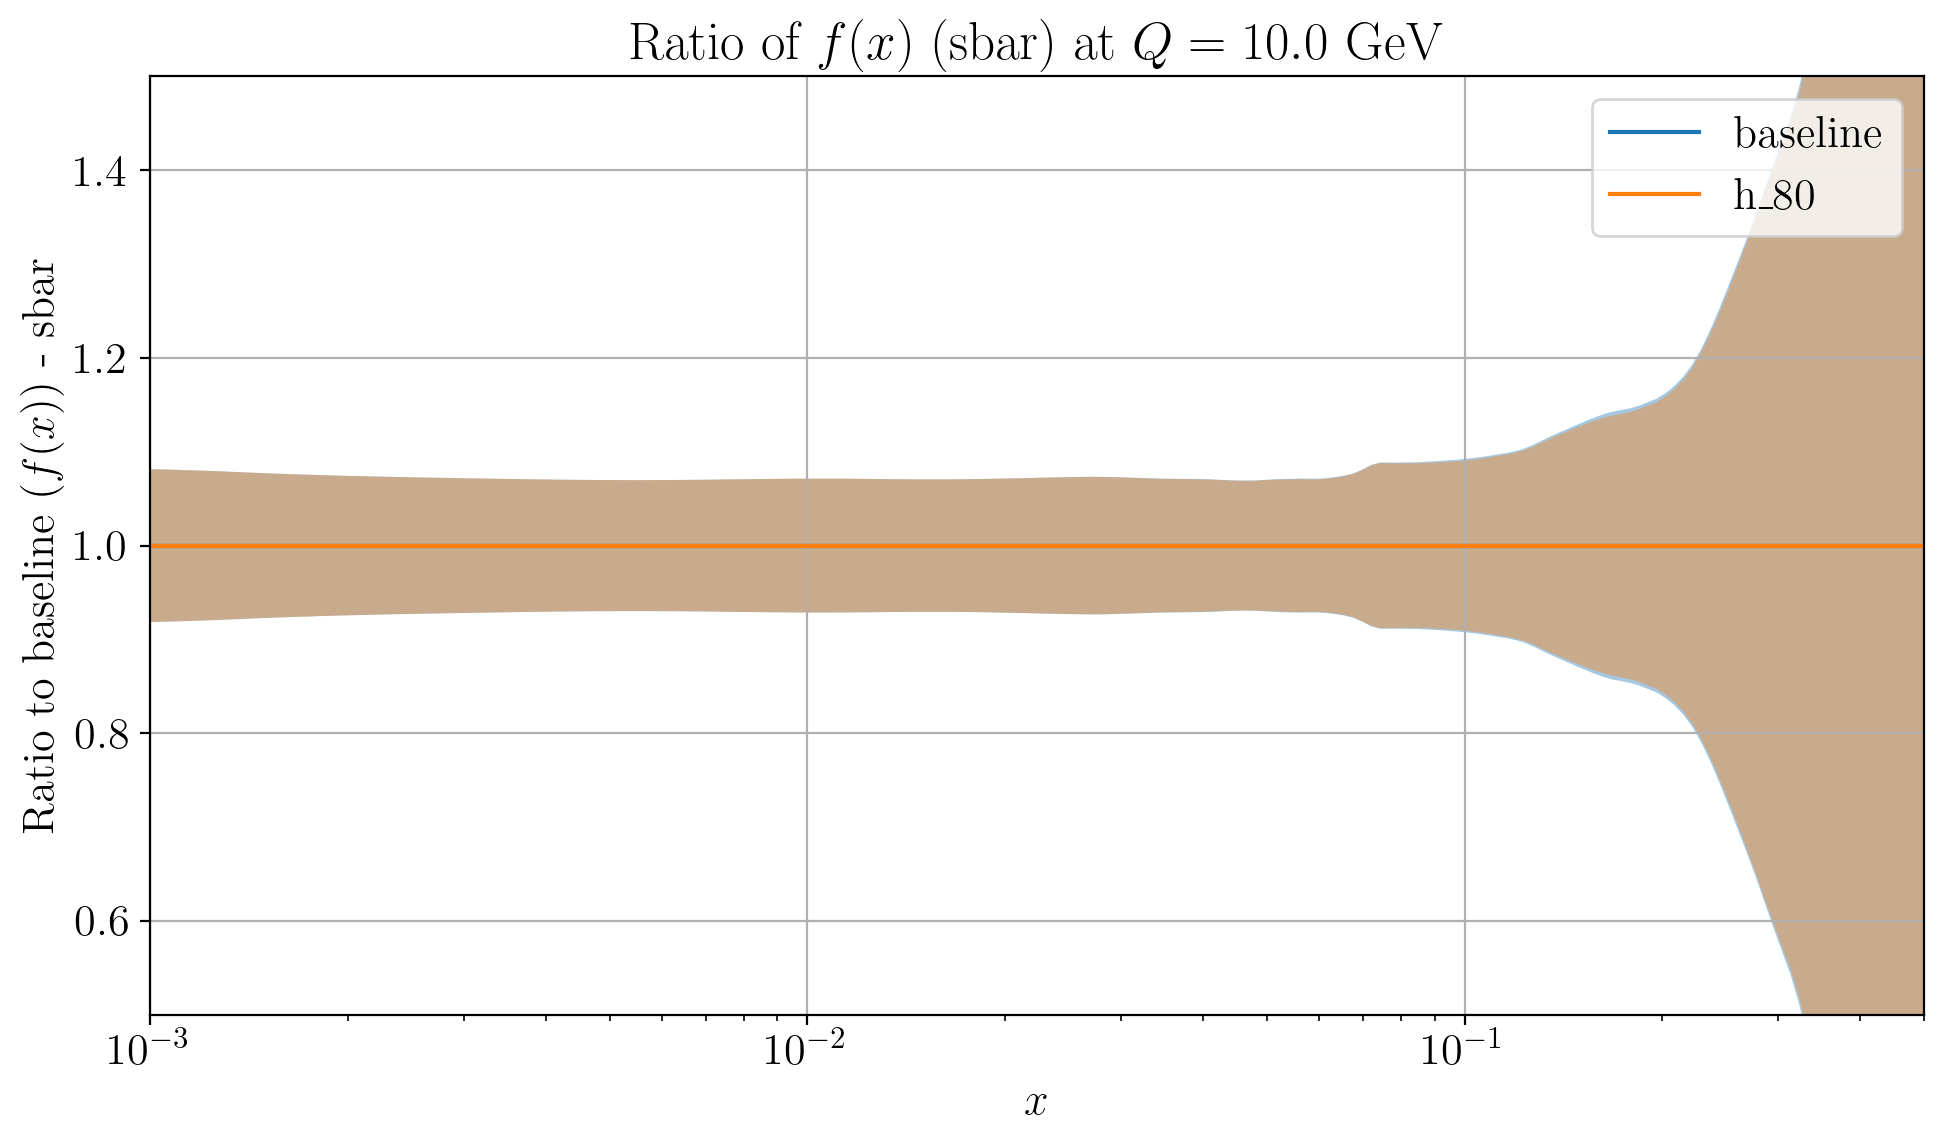

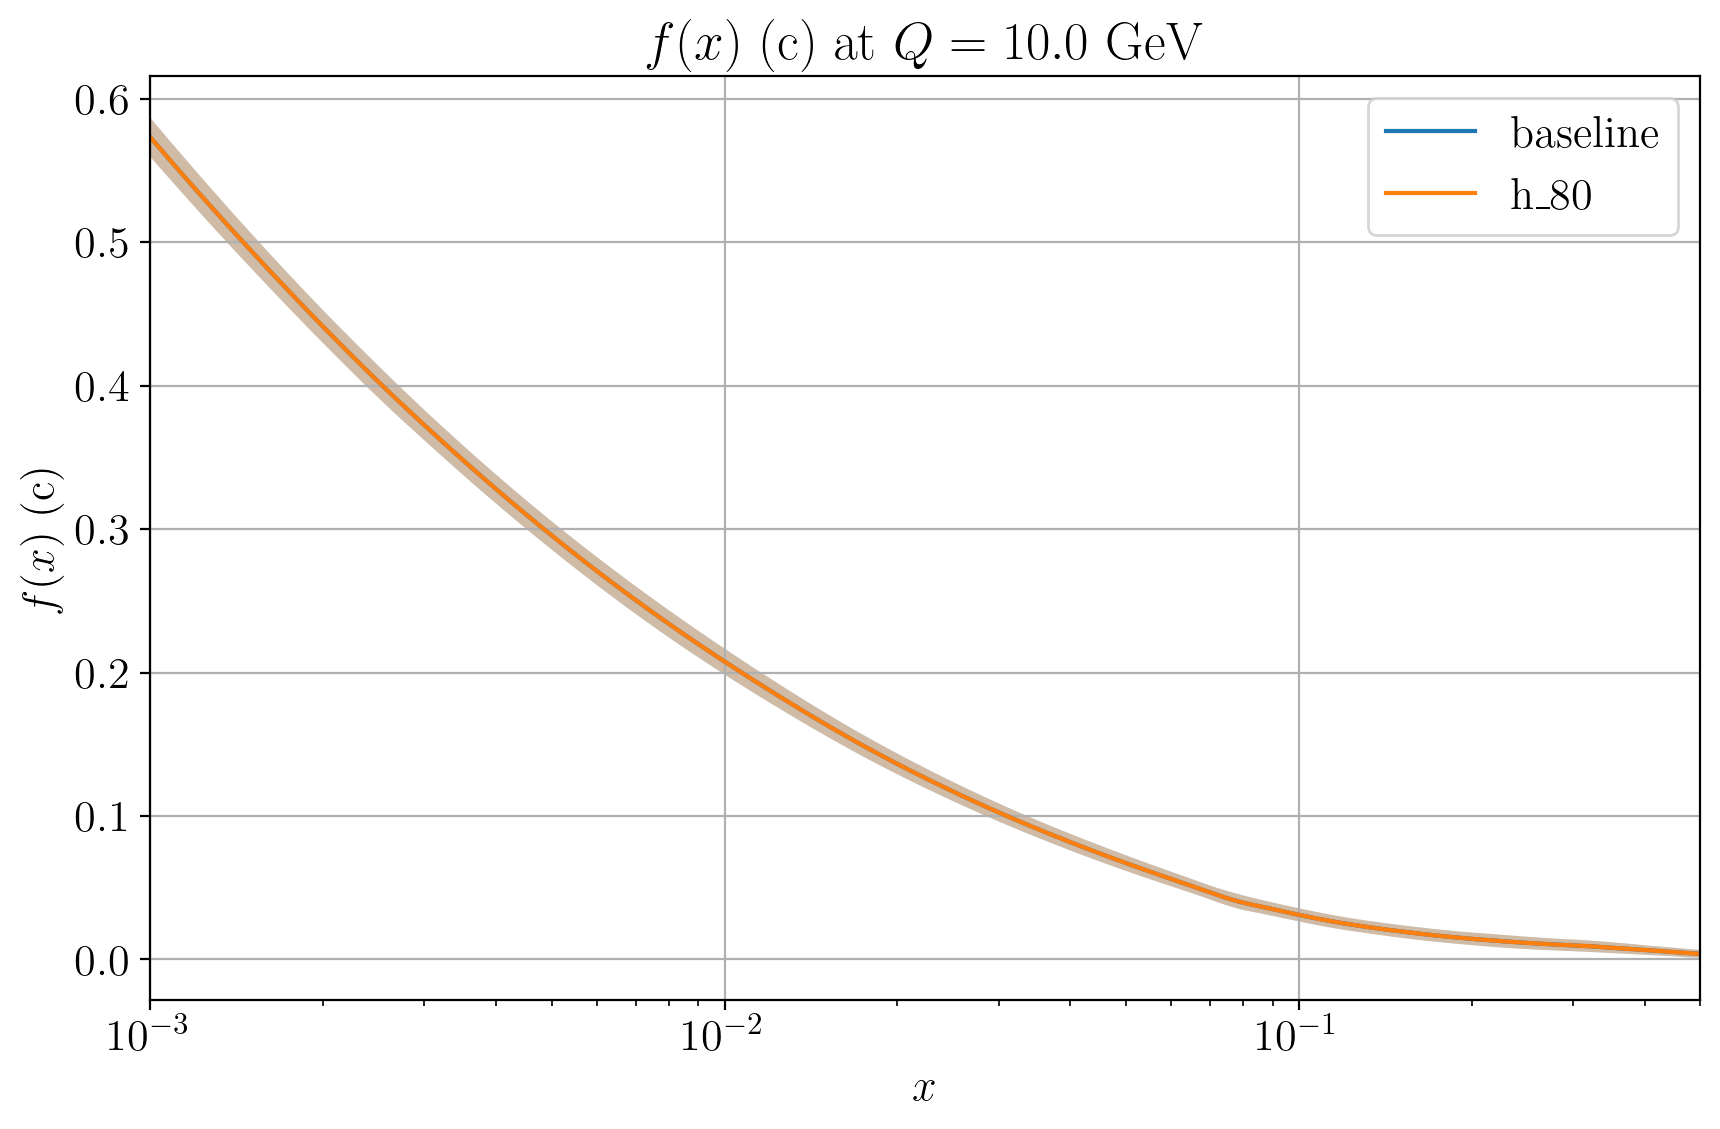

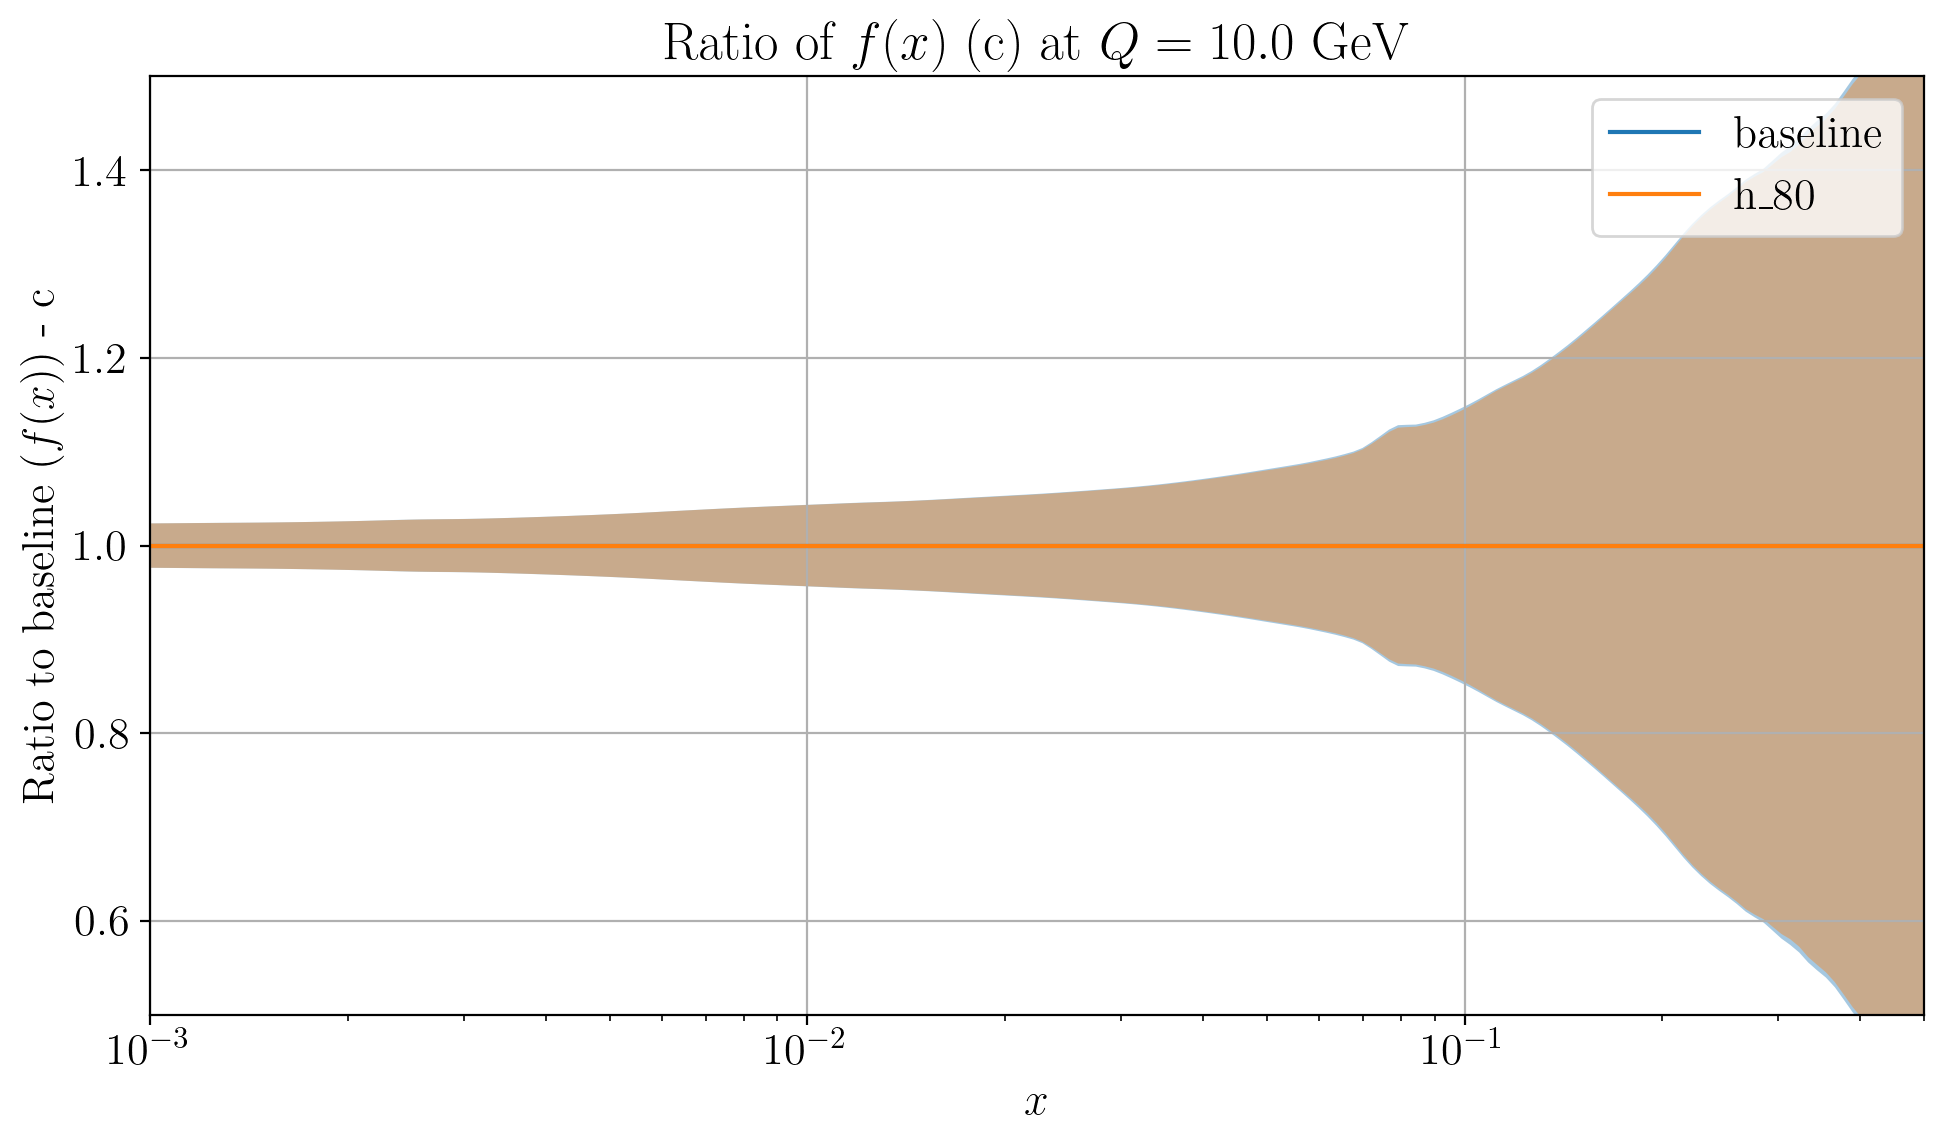

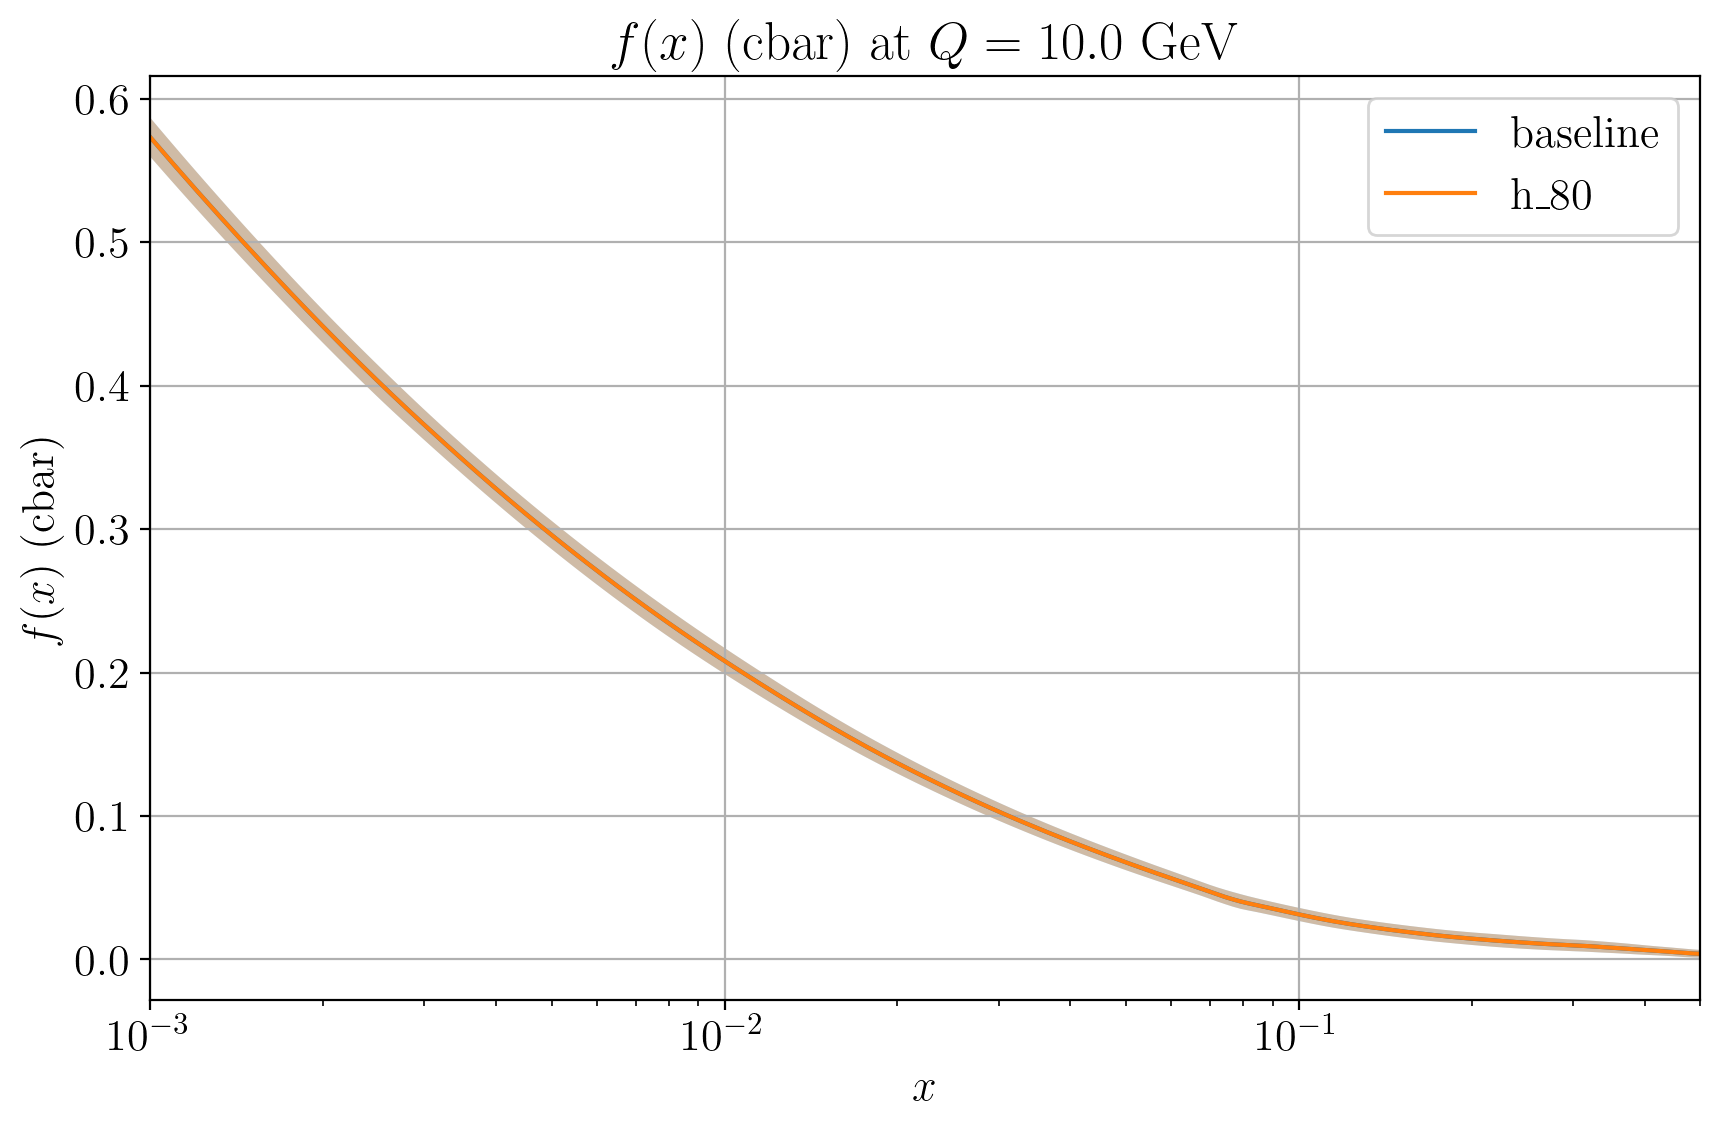

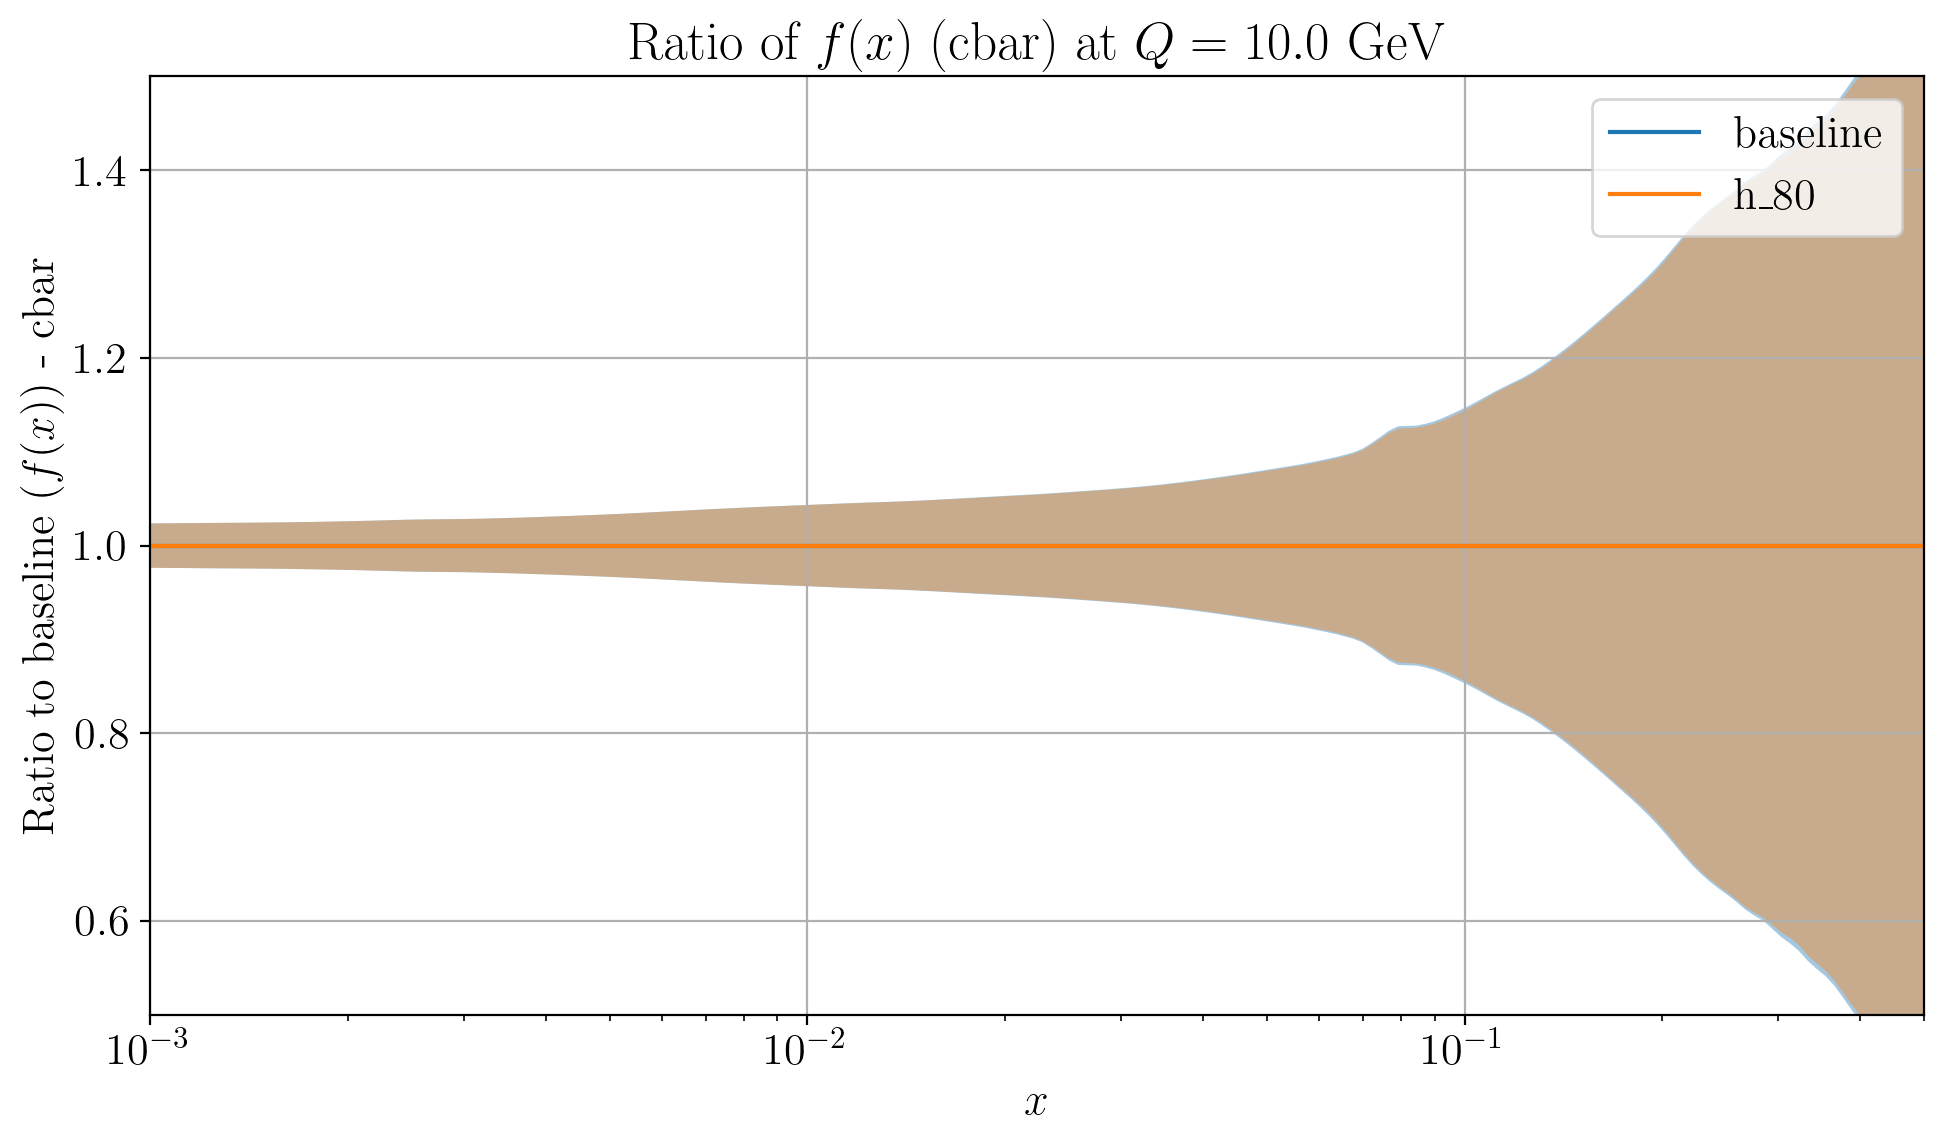

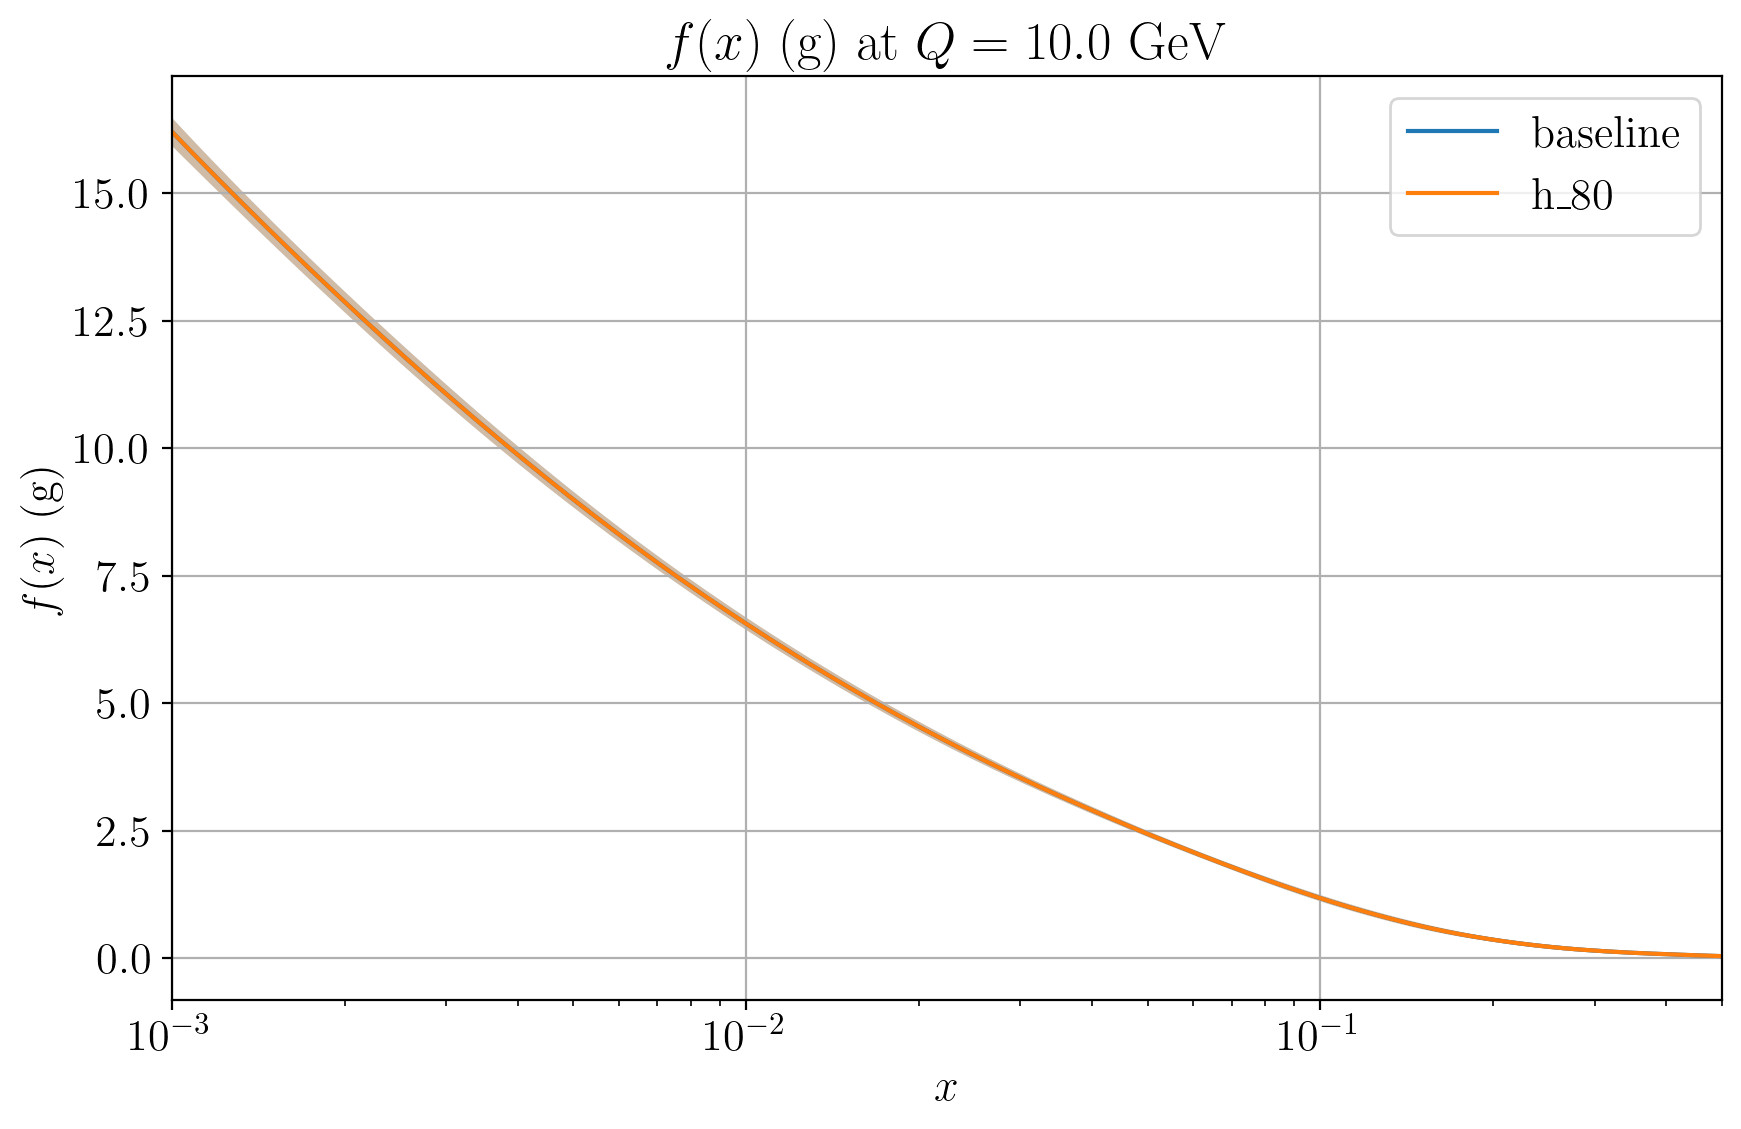

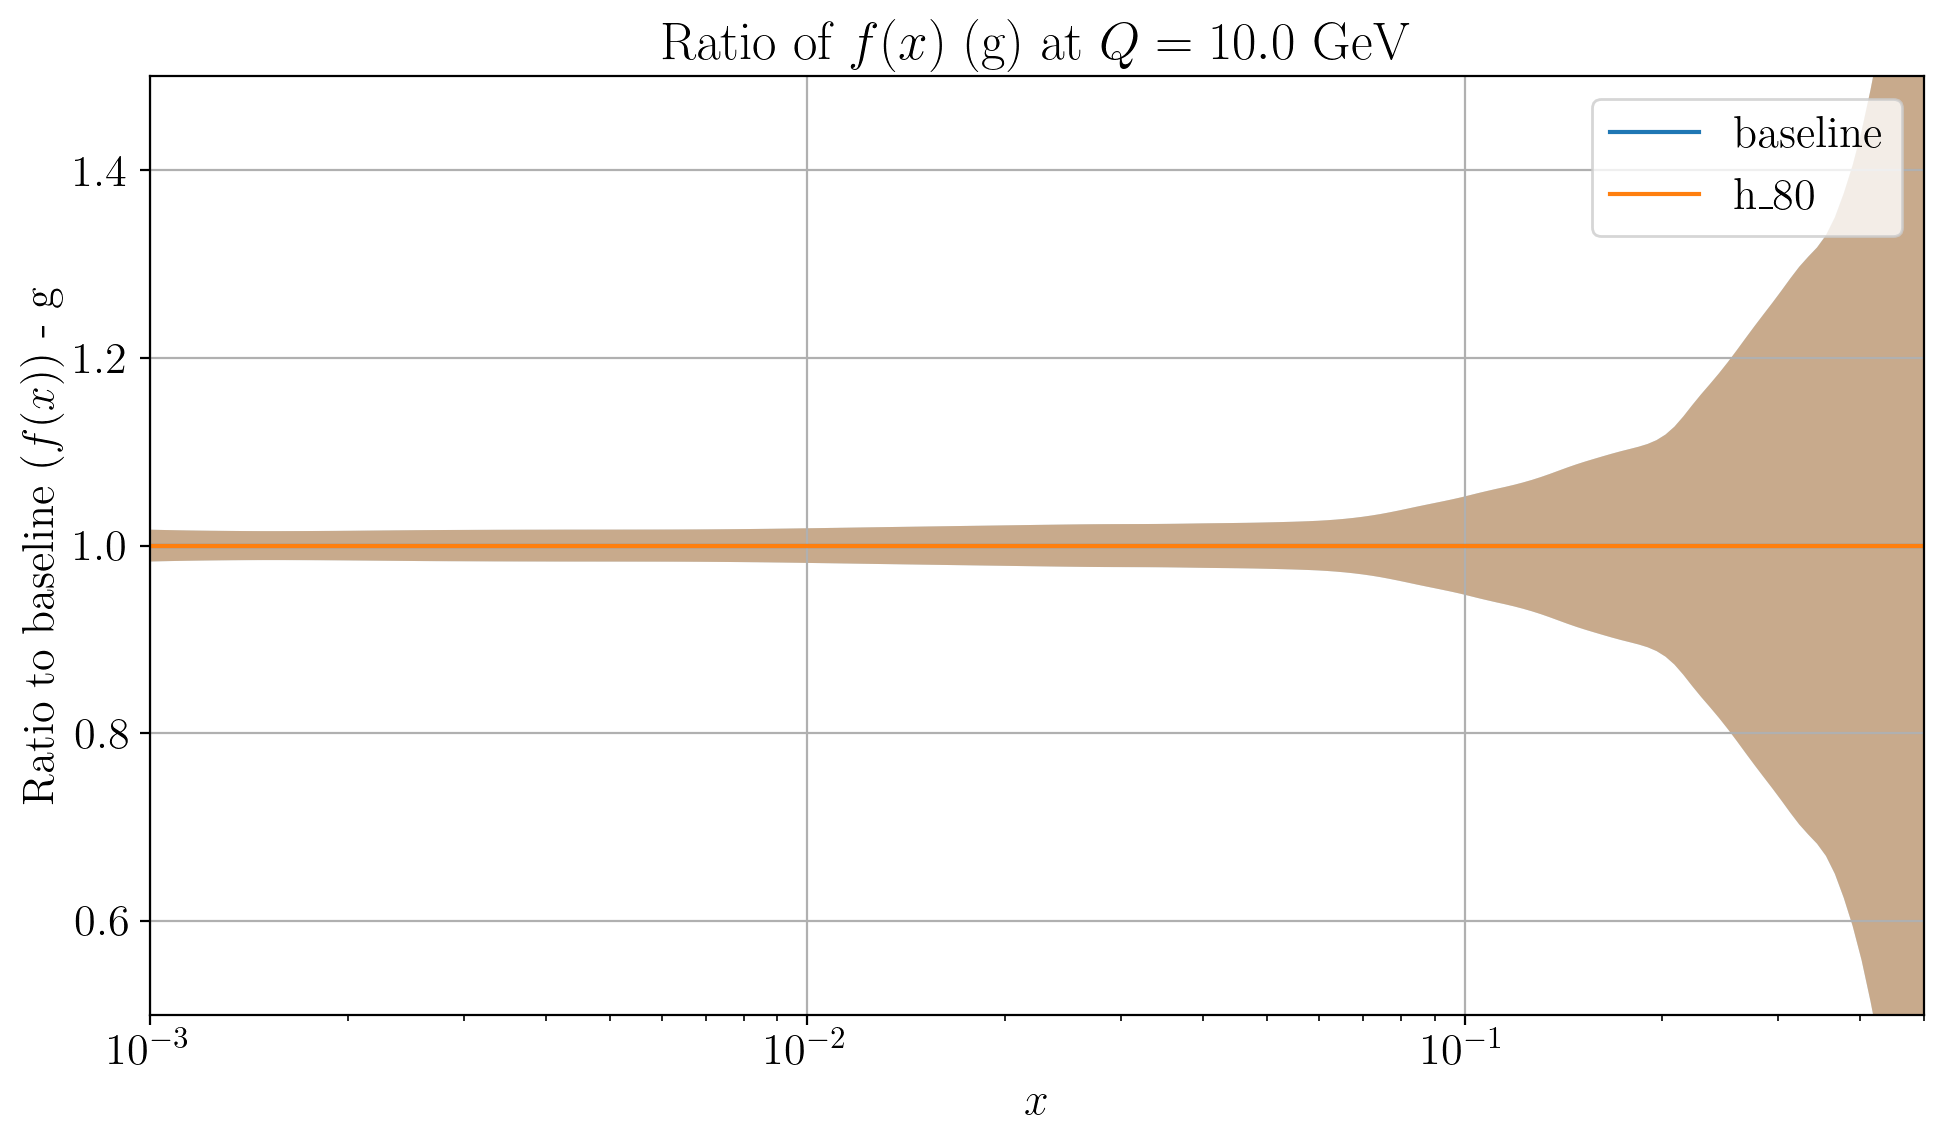

In [48]:
baseline_name = "baseline"

# Plot for each flavor
for flavor in flavors:
    # Plot 1: Absolute values (unchanged)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    
    for set_name in pdf_sets:
        central = central_values[flavor][set_name]
        err_plus, err_minus = uncertainties[flavor][set_name]
        
        # Plot central values
        ax1.plot(xs, central, label=f'{set_name}')

        # Plot uncertainty band
        ax1.fill_between(xs, central - err_minus, central + err_plus, alpha=0.3)

    # Customise Plot 1 (Absolute Values)
    x_min = np.min(xs)
    x_max = np.max(xs)

    ax1.set_xscale('log')
    ax1.set_xlabel(r'$x$')
    #ax1.set_yscale('log')
    #ax1.set_ylabel(rf'$z D^{{K^*}}_{flavor}(z)$')
    ax1.set_ylabel(rf'$f(x)$ ({flavor})')
    ax1.set_title(rf'$f(x)$ ({flavor}) at $Q = {Q}$ GeV')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    ax1.set_xlim(x_min, x_max)
    #ax1.set_ylim(0.8*1e-3, 1.2 * 1e0)  # Adjust y-axis limits for better visibility

    # Plot 2: Ratio to PDF4LHC21_900 (baseline)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    # Extract baseline values
    baseline_central = central_values[flavor][baseline_name]
    baseline_err_plus, baseline_err_minus = uncertainties[flavor][baseline_name]

    # Plot all PDF sets as ratios to the baseline
    for set_name in pdf_sets:
        if set_name == baseline_name:
            # For baseline, plot ratio=1 with uncertainties
            ratio_central = np.ones_like(baseline_central)
            ratio_upper = (baseline_central + baseline_err_plus) / baseline_central
            ratio_lower = (baseline_central - baseline_err_minus) / baseline_central
        else:
            # For other sets, compute ratio to baseline
            central = central_values[flavor][set_name]
            err_plus, err_minus = uncertainties[flavor][set_name]
            
            ratio_central = central / baseline_central
            ratio_upper = (central + err_plus) / baseline_central
            ratio_lower = (central - err_minus) / baseline_central
        
        # Plot central ratio
        ax2.plot(xs, ratio_central, label=f'{set_name}')

        # Plot uncertainty band
        ax2.fill_between(xs, ratio_lower, ratio_upper, alpha=0.4)

    # Customise Plot 2 (Ratio)
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(rf'Ratio to baseline ($f(x)$) - {flavor}')
    ax2.set_title(rf'Ratio of $f(x)$ ({flavor}) at $Q = {Q}$ GeV')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0.5, 1.5)  # Adjust y-axis limits for the ratio plot
    
    # Display the plots
    plt.tight_layout()
    plt.show()

Calculating some cross sections

# Old files

# Charge conjugation assessment

In [38]:
# Define the kaon FF sets
kaon_sets = {
    "mapff": lhapdf.getPDFSet("MAPFF10NLOKAp"),
    "mapff_m": lhapdf.getPDFSet("MAPFF10NLOKAm"),
}

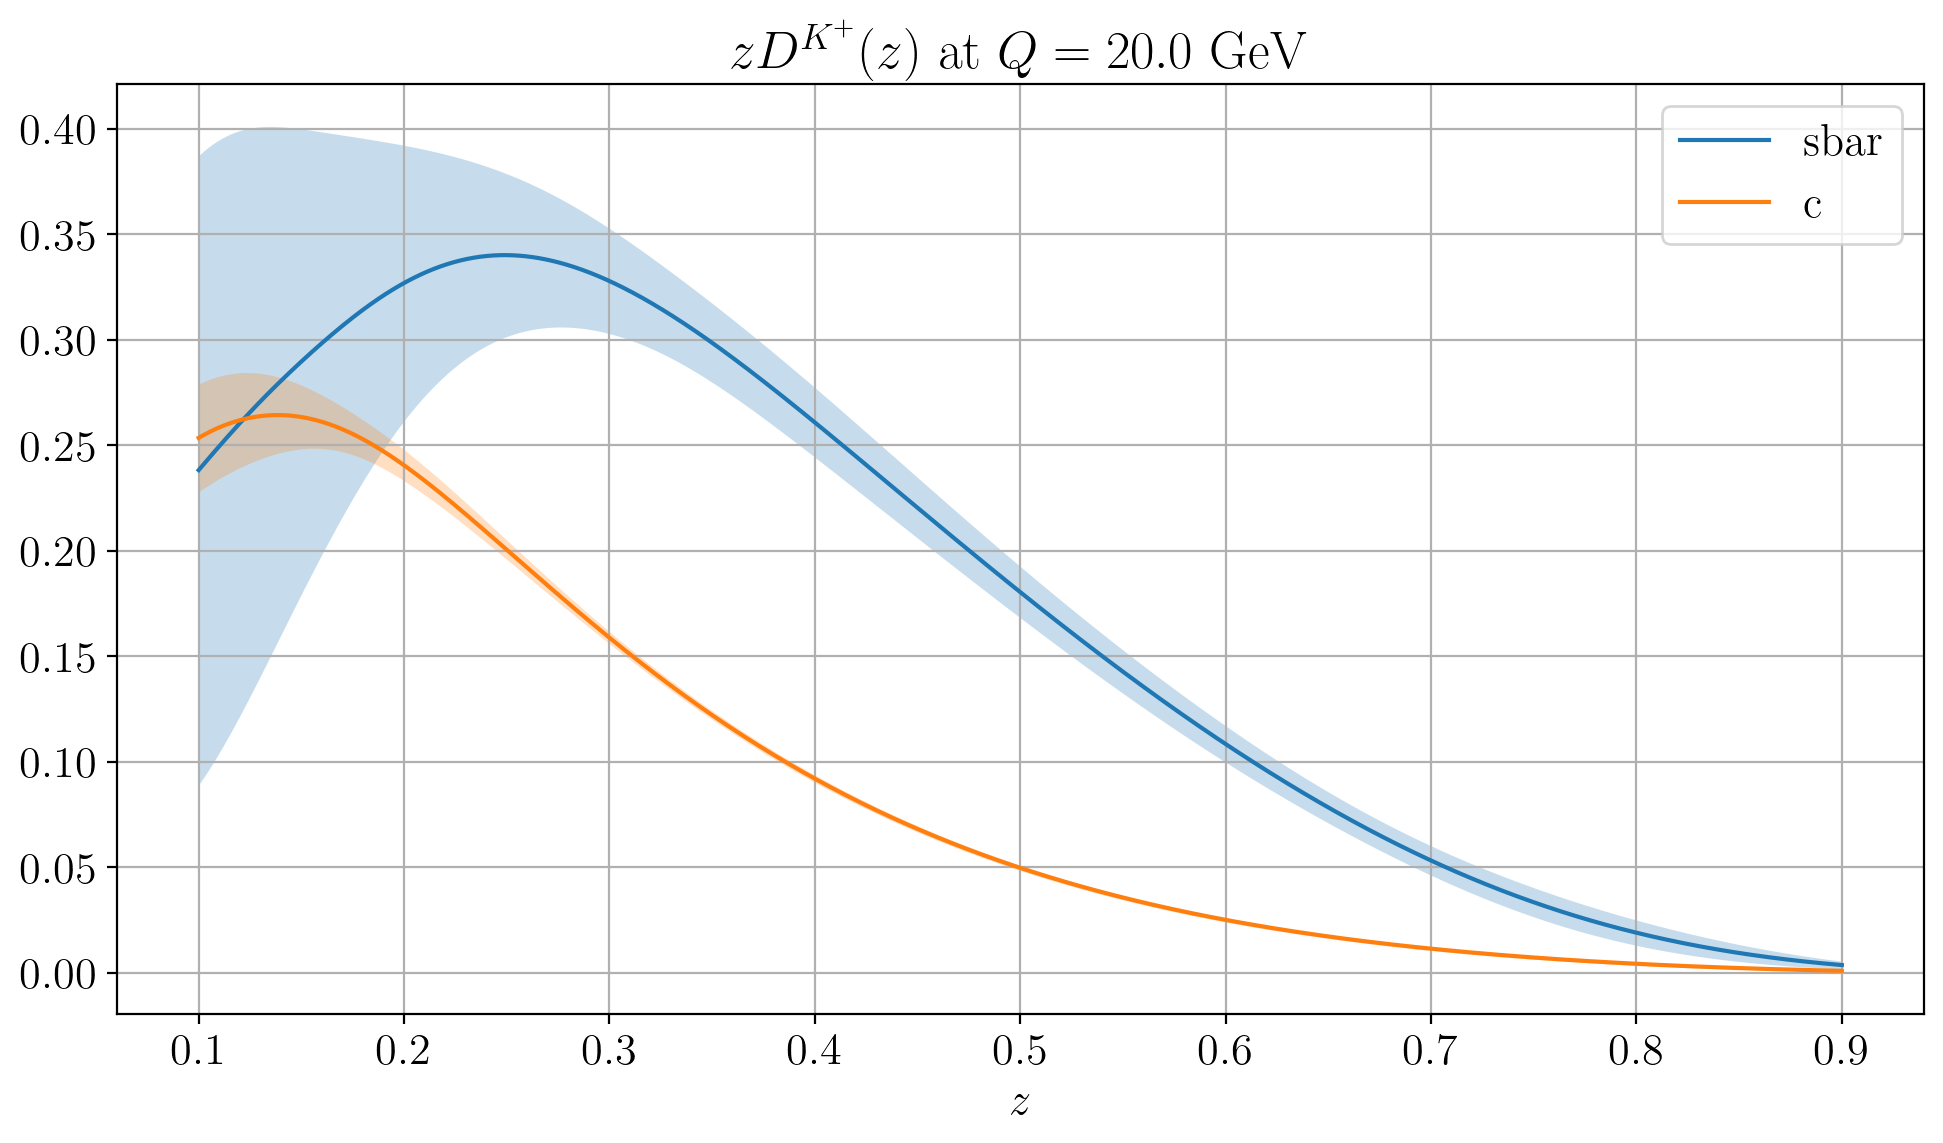

In [64]:
# Short plot with uncertainties
flavor_p = "sbar"
flavor_m = "c"

mapff1_central = central_values[flavor_p]["mapff"]
mapff2_central = central_values[flavor_m]["mapff"]

# get uncertainties (err_plus, err_minus) for each set
errp_plus, errp_minus = uncertainties[flavor_p]["mapff"]
errm_plus, errm_minus = uncertainties[flavor_m]["mapff"]

fig, ax = plt.subplots(figsize=(10, 6))
# central lines
ax.plot(zs, mapff1_central, label=f'{flavor_p}', linestyle='-')
ax.plot(zs, mapff2_central, label=f'{flavor_m}', linestyle='-')

# uncertainty bands
ax.fill_between(zs, mapff1_central - errp_minus, mapff1_central + errp_plus,
                color='C0', alpha=0.25, linewidth=0)
ax.fill_between(zs, mapff2_central - errm_minus, mapff2_central + errm_plus,
                color='C1', alpha=0.25, linewidth=0)

ax.set_xlabel(r'$z$')
#ax.set_ylabel(rf'$z FF(z)$')
ax.set_title(rf'$z D^{{K^+}}(z)$ at $Q = {Q}$ GeV')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()

# Define binning in z and Q2 (10 and 3 TeV scenario)

In [55]:
# Number of bins
n_bins = 24  

# Bin edges: logarithmic spacing from 1e1 to 1e3
#q2_edges = np.logspace(1, 4, n_bins + 1)
q2_edges = np.logspace(1, np.log10(3000), n_bins + 1)

# Bin centers: arithmetic mean of edges
q2_centers = 0.5 * (q2_edges[:-1] + q2_edges[1:])

# Define z range for integration
z_min_kff = 0.5
z_max_kff = 0.9
z_range_kff = np.linspace(z_min_kff, z_max_kff, 200)


In [57]:
# Define parton channels and their labels
parton_channels = {
    'g': 'g',
    'd': 'd',
    'u': 'u',
    's': 's',
    'c': 'c',
    'b': 'b',
    'dbar': 'dbar',
    'ubar': 'ubar',
    'sbar': 'sbar',
    'cbar': 'cbar',
    'bbar': 'bbar'
}


# Create master export - K FFs

In [58]:
n_members_kff = 161  # Number of members in the Hessian ensemble including central

# Iterate over each parton channel
for channel, parton_label in parton_channels.items():
    # Initialize array to store integrals: 24 bins, 81 integrals each (central + 80 symmetric Hessian)
    integrals_array = np.zeros((len(q2_centers), n_members_kff))
    
    # Loop over each bin center (mu2_value)
    for bin_idx, mu2_value in enumerate(q2_centers):
        # Compute central integral
        central_values = [dff.zK_160(channel, z, mu2_value) / z for z in z_range_kff]
        central_integral = np.trapz(central_values, z_range_kff)

        # Compute error integrals for each eigenvector ID (1-160)
        error_integrals = []
        for eigen_id in range(n_members_kff - 1): # -1 is because we already got rid of the central in py_dff at this point
            # Error direction
            error_values = [dff.zK_sym_160(channel, z, mu2_value)[eigen_id] / z for z in z_range_kff]
            integral_error = np.trapz(error_values, z_range_kff)
            error_integrals.append(integral_error)
                    
        # Inside the loop where integrals are computed:
        row = [central_integral, *error_integrals]
        integrals_array[bin_idx, :] = row
    
    # Save to file for this parton channel
    filename = f"251113_3tev_KFFs_160/{parton_label}_KFFs.txt"
    error_headers = ' '.join([f'error{i}' for i in range(1, n_members_kff)])
    header = f'Q2_value central {error_headers}'
    np.savetxt(filename, np.hstack((np.array(q2_centers)[:, np.newaxis], integrals_array)),
               fmt='%.6e', delimiter=' ', header=header)
    
    print(f"Saved results for {parton_label} to {filename}")

Saved results for g to 251113_3tev_KFFs_160/g_KFFs.txt
Saved results for d to 251113_3tev_KFFs_160/d_KFFs.txt
Saved results for u to 251113_3tev_KFFs_160/u_KFFs.txt
Saved results for s to 251113_3tev_KFFs_160/s_KFFs.txt
Saved results for c to 251113_3tev_KFFs_160/c_KFFs.txt
Saved results for b to 251113_3tev_KFFs_160/b_KFFs.txt
Saved results for dbar to 251113_3tev_KFFs_160/dbar_KFFs.txt
Saved results for ubar to 251113_3tev_KFFs_160/ubar_KFFs.txt
Saved results for sbar to 251113_3tev_KFFs_160/sbar_KFFs.txt
Saved results for cbar to 251113_3tev_KFFs_160/cbar_KFFs.txt
Saved results for bbar to 251113_3tev_KFFs_160/bbar_KFFs.txt


# Check potential bug *z - kaon

In [36]:
q2_test = 370
zs_test = np.linspace(0.5, 0.9, 100)

zK_test = [dff.zK_160("sbar", z, q2_test) for z in zs_test]
K_test = zK_test / zs_test

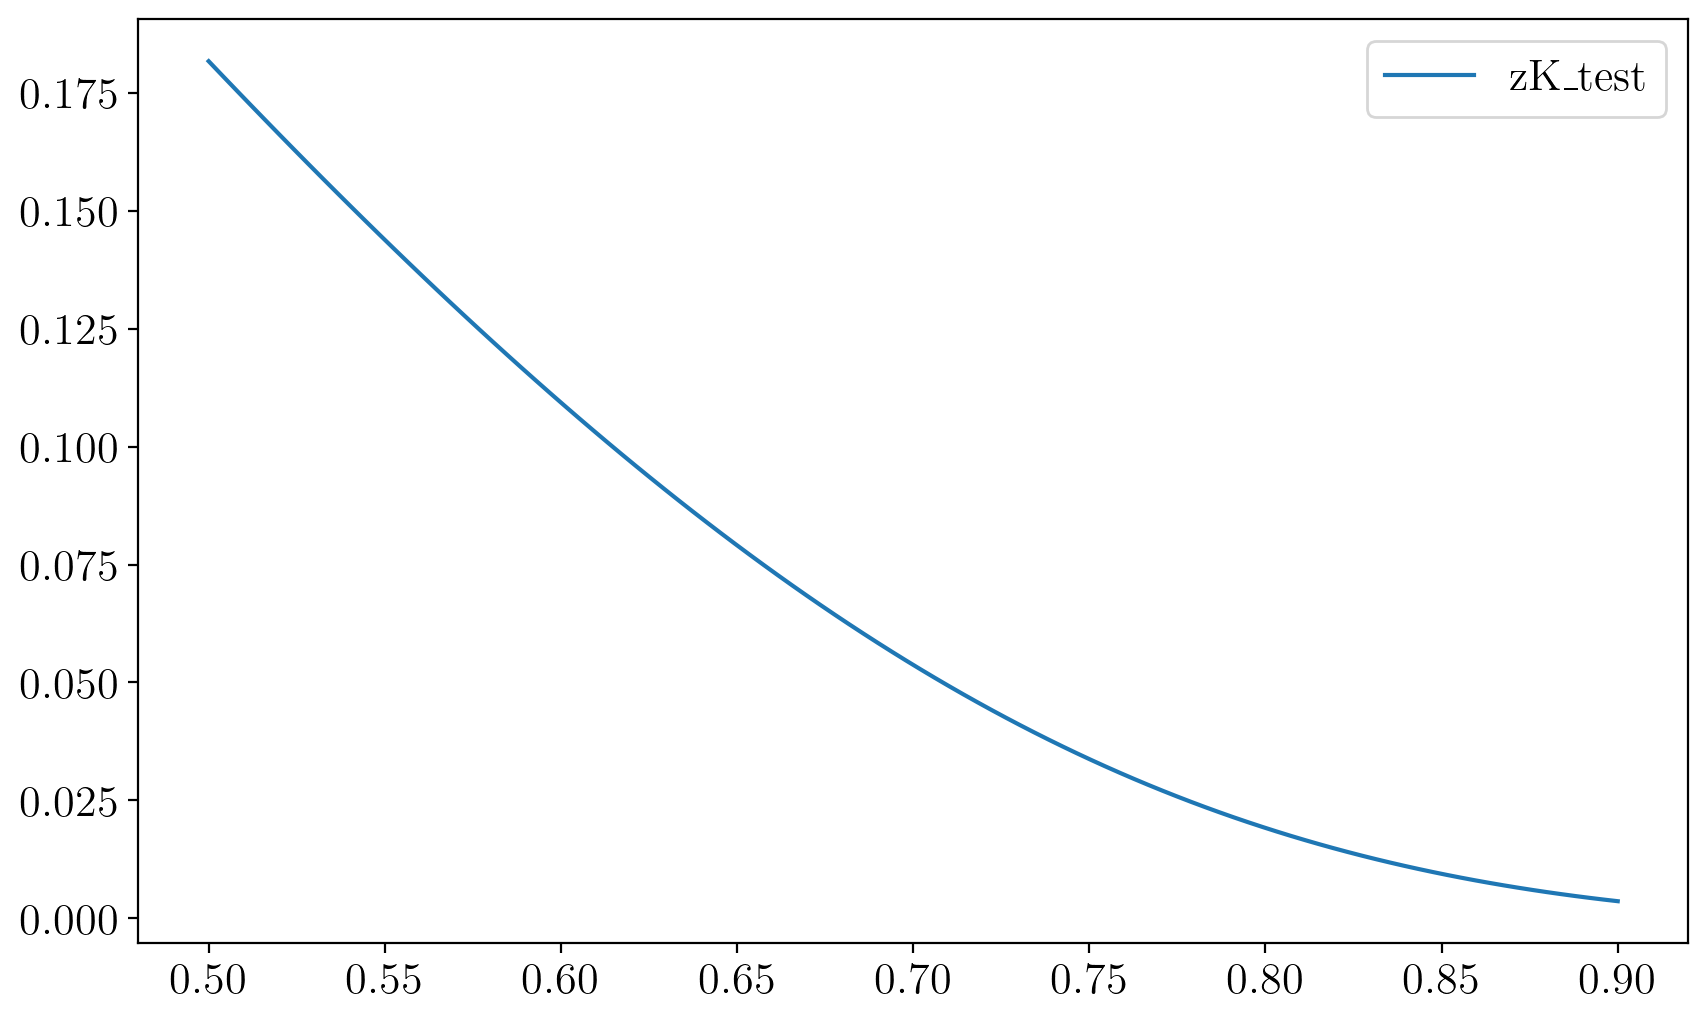

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(zs_test, zK_test, label='zK_test')
#ax.plot(zs_test, K_test, label='K_test', linestyle='--')
#ax.set_xscale('log')
ax.legend()

In [38]:
# Calculate the integral of K and zK over z from 0.1 to 0.9
integral_zK = np.trapz(zK_test, zs_test)
integral_K = np.trapz(K_test, zs_test)

# print the integrals
print(f"Integral of zK from 0.5 to 0.9: {integral_zK}")
print(f"Integral of K from 0.5 to 0.9: {integral_K}")

Integral of zK from 0.5 to 0.9: 0.026902868282848113
Integral of K from 0.5 to 0.9: 0.04483791123577868


# Check potential bug *z - B hadron

In [5]:
q_test = 172
q2_test = q_test**2

zs_test = np.linspace(0.1, 0.9, 100)

zB_test = [dff.zB_40("b", z, q2_test) for z in zs_test]
B_test = [dff.zB_40("b", z, q2_test) / z for z in zs_test]

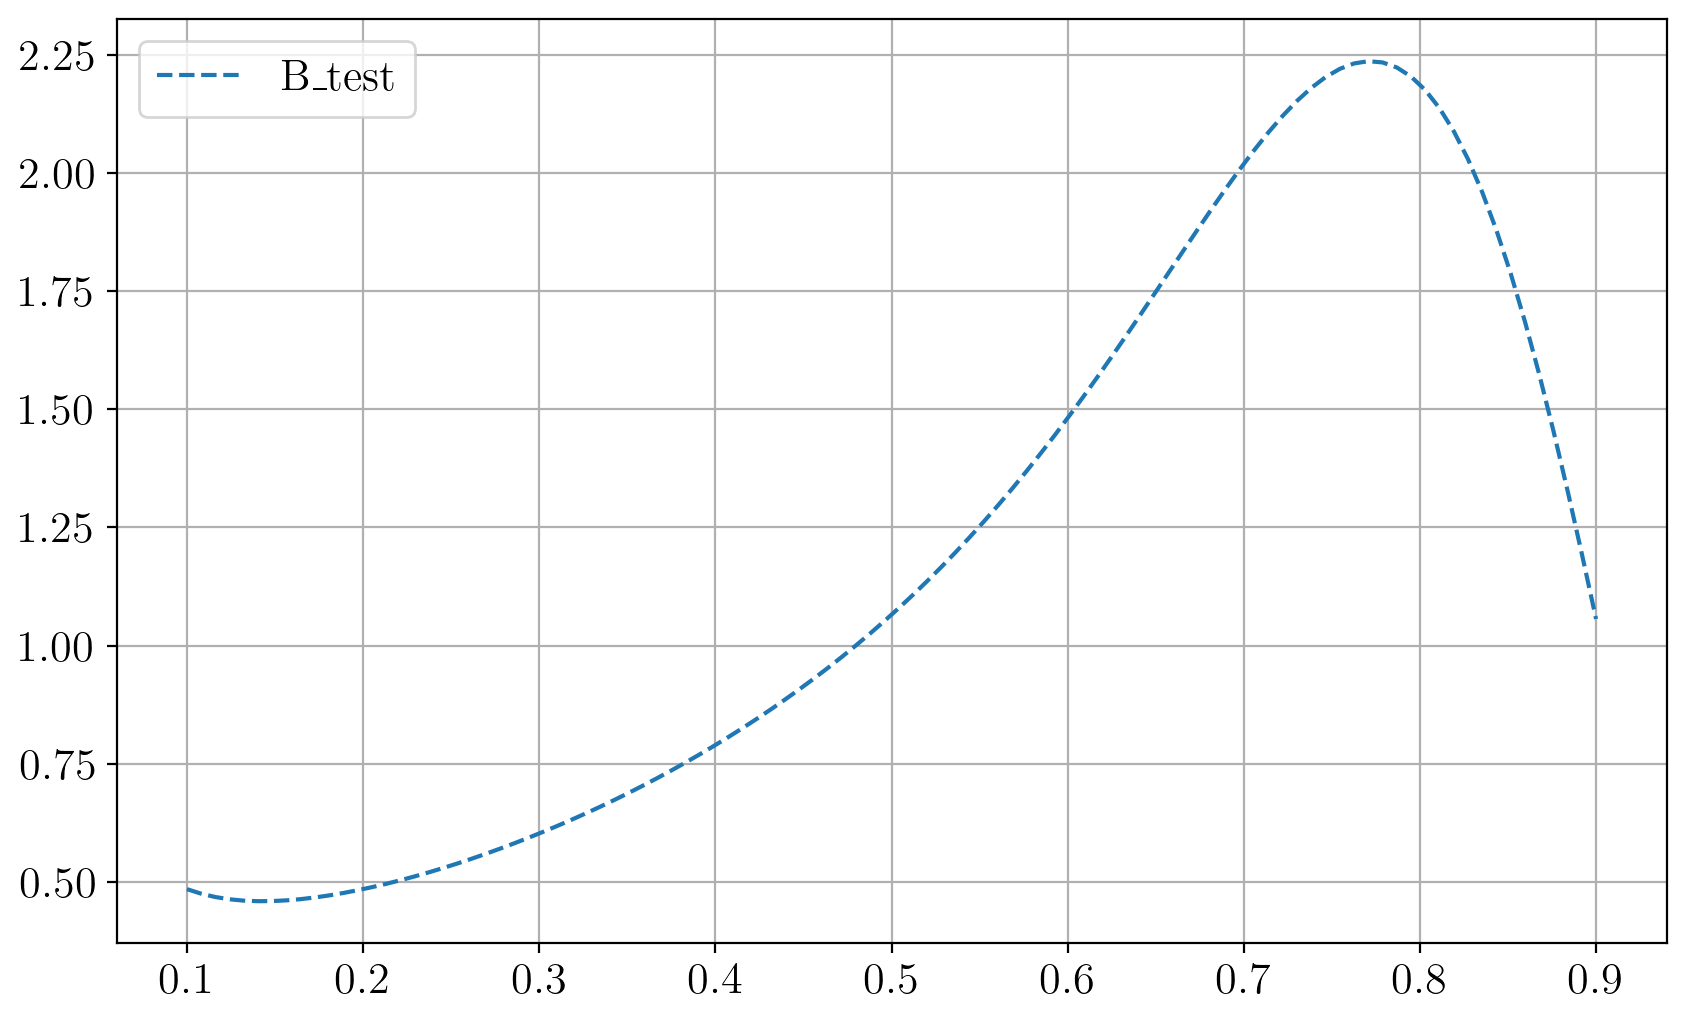

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(zs_test, zB_test, label='zB_test')
ax.plot(zs_test, B_test, label='B_test', linestyle='--')
#ax.set_xscale('log')
ax.legend()
ax.grid()

In [7]:
# Calculate the integral of B and zB over z from 0.1 to 0.9
integral_zB = np.trapz(zB_test, zs_test)
integral_B = np.trapz(B_test, zs_test)

# print the integrals
print(f"Integral of zB from 0.1 to 0.9: {integral_zB}")
print(f"Integral of B from 0.1 to 0.9: {integral_B}")

Integral of zB from 0.1 to 0.9: 0.5804169051867206
Integral of B from 0.1 to 0.9: 0.9537141136389616


# Check potential bug D*

In [32]:
mz = 90
q2_test = mz**2

zs_test = np.linspace(0.1, 0.9, 100)

zD_test = [(dff.zD("c", z, q2_test) + dff.zD("cbar", z, q2_test)) for z in zs_test]
D_test = [(dff.zD("c", z, q2_test) + dff.zD("cbar", z, q2_test)) /z for z in zs_test]

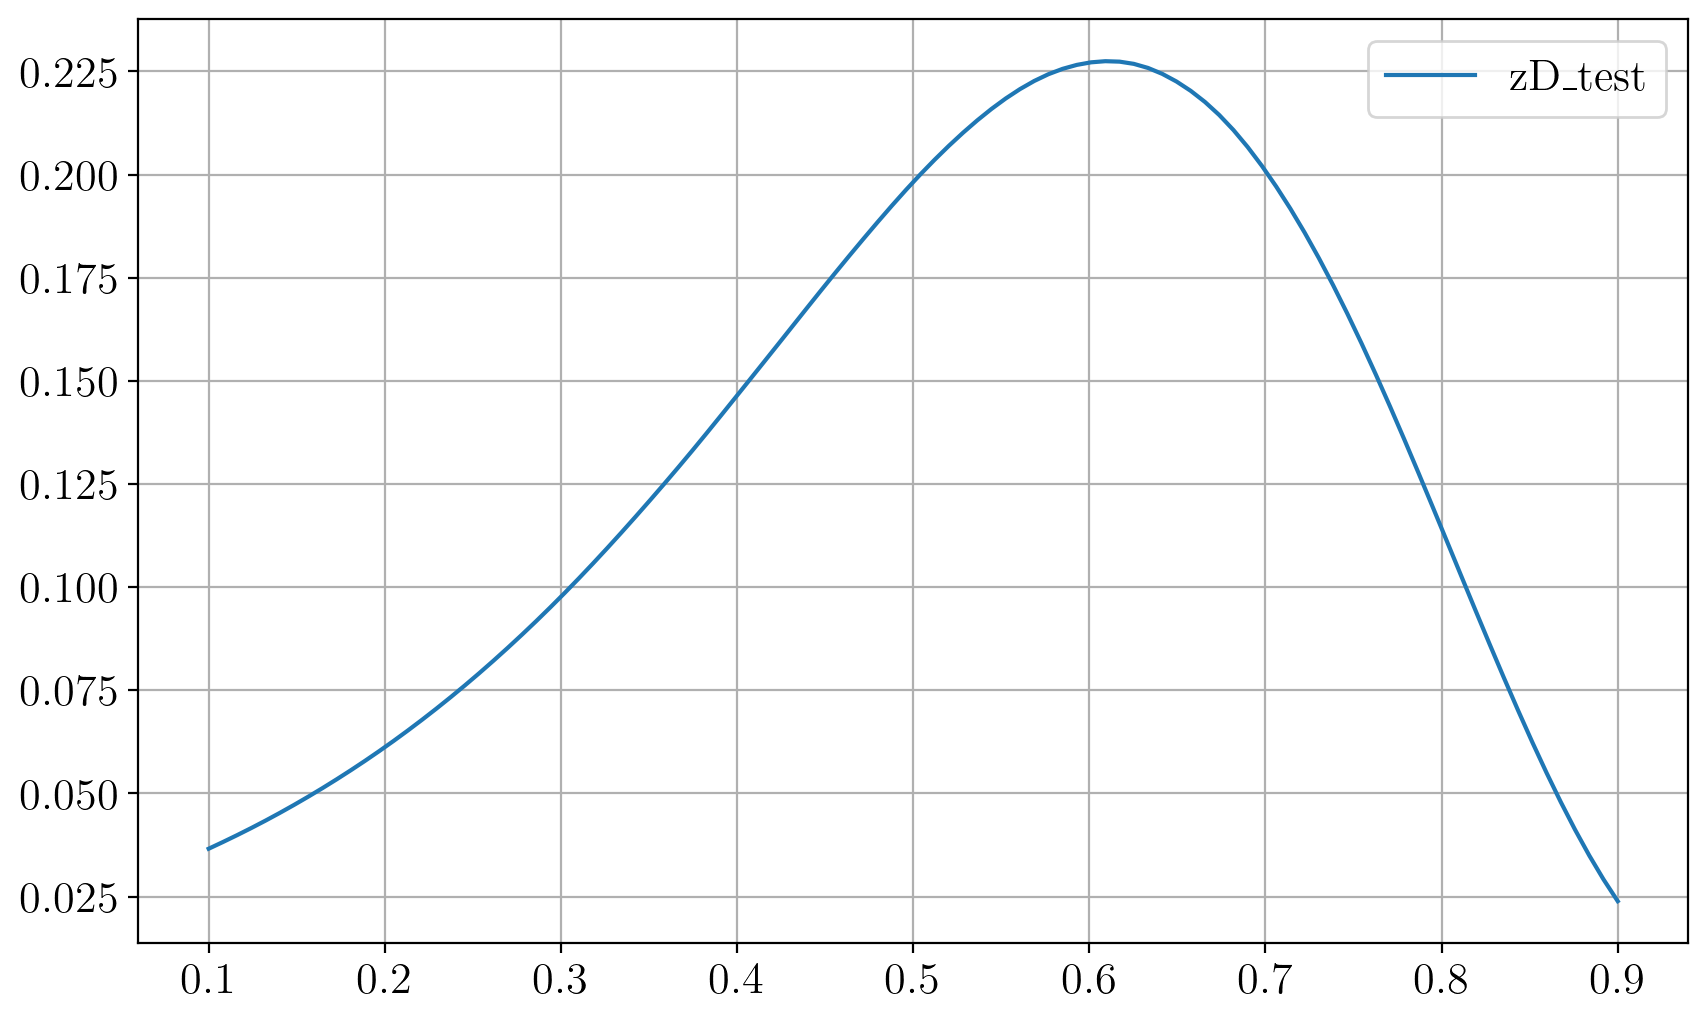

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(zs_test, zD_test, label='zD_test')
#ax.plot(zs_test, D_test, label='D_test', linestyle='--')
ax.legend()
ax.grid()

# Create master export - D FFs

In [67]:
# Define z range for integration
z_min_dff = 0.3
z_max_dff = 0.9
z_range_dff = np.linspace(z_min_dff, z_max_dff, 1000)

In [68]:
n_members_dff = 17  # Number of members in the Hessian ensemble including central

# Iterate over each parton channel
for channel, parton_label in parton_channels.items():
    # Initialize array to store integrals: 24 bins, 17 integrals each (central + 8 plus + 8 minus)
    integrals_array = np.zeros((len(q2_centers), n_members_dff))

    # Loop over each bin center (mu2_value)
    for bin_idx, mu2_value in enumerate(q2_centers):
        # Compute central integral
        central_values = [dff.zD(channel, z, mu2_value) / z for z in z_range_dff]
        central_integral = np.trapz(central_values, z_range_dff)

        # Compute plus and minus integrals for each eigenvector ID (1-8)
        plus_integrals = []
        minus_integrals = []
        for eigen_id in range(1, 9):
            # Plus direction
            plus_values = [dff.zD_plus(channel, z, mu2_value, eigen_id) / z for z in z_range_dff]
            integral_plus = np.trapz(plus_values, z_range_dff)
            plus_integrals.append(integral_plus)
            
            # Minus direction
            minus_values = [dff.zD_minus(channel, z, mu2_value, eigen_id) / z for z in z_range_dff]
            integral_minus = np.trapz(minus_values, z_range_dff)
            minus_integrals.append(integral_minus)
        
        # Inside the loop where integrals are computed:
        row = [central_integral, *plus_integrals, *minus_integrals]
        integrals_array[bin_idx, :] = row
    
    # Save to file for this parton channel
    filename = f"251112_3tev_ffs/DFF/{parton_label}_DFFs.txt"
    np.savetxt(filename, np.hstack((np.array(q2_centers)[:, np.newaxis], integrals_array)),
               fmt='%.6e', delimiter=' ',
               header='Q2_value central plus1 plus2 plus3 plus4 plus5 plus6 plus7 plus8 minus1 minus2 minus3 minus4 minus5 minus6 minus7 minus8')
    
    print(f"Saved results for {parton_label} to {filename}")


Saved results for g to 251112_3tev_ffs/DFF/g_DFFs.txt
Saved results for d to 251112_3tev_ffs/DFF/d_DFFs.txt
Saved results for u to 251112_3tev_ffs/DFF/u_DFFs.txt
Saved results for s to 251112_3tev_ffs/DFF/s_DFFs.txt
Saved results for c to 251112_3tev_ffs/DFF/c_DFFs.txt
Saved results for b to 251112_3tev_ffs/DFF/b_DFFs.txt
Saved results for dbar to 251112_3tev_ffs/DFF/dbar_DFFs.txt
Saved results for ubar to 251112_3tev_ffs/DFF/ubar_DFFs.txt
Saved results for sbar to 251112_3tev_ffs/DFF/sbar_DFFs.txt
Saved results for cbar to 251112_3tev_ffs/DFF/cbar_DFFs.txt
Saved results for bbar to 251112_3tev_ffs/DFF/bbar_DFFs.txt


In [71]:
list(range(1, 9))

[1, 2, 3, 4, 5, 6, 7, 8]

# Create master exports - B FFs, 8 members

In [72]:
# Define z range for integration
z_min_bff = 0.7
z_max_bff = 0.9
z_range_bff = np.linspace(z_min_bff, z_max_bff, 1000)

In [ ]:
n_members_bff = 9  # Number of members in the Hessian ensemble including central

# Iterate over each parton channel
for channel, parton_label in parton_channels.items():
    # Initialize array to store integrals: 24 bins, 9 integrals each (central + 8 symmetric Hessian)
    integrals_array = np.zeros((len(q2_centers), n_members_bff))
    
    # Loop over each bin center (mu2_value)
    for bin_idx, mu2_value in enumerate(q2_centers):
        # Compute central integral
        central_values = [dff.zB(channel, z, mu2_value) / z for z in z_range_bff]
        central_integral = np.trapz(central_values, z_range_bff)

        # Compute error integrals for each eigenvector ID (1-8)
        error_integrals = []
        for eigen_id in range(n_members_bff - 1): # -1 is because we already got rid of the central in py_dff at this point
            # Error direction
            error_values = [dff.zB_sym(channel, z, mu2_value)[eigen_id] / z for z in z_range_bff]
            integral_error = np.trapz(error_values, z_range_bff)
            error_integrals.append(integral_error)
                    
        # Inside the loop where integrals are computed:
        row = [central_integral, *error_integrals]
        integrals_array[bin_idx, :] = row
    
    # Save to file for this parton channel
    filename = f"251112_3tev_ffs/BFF/8_members/{parton_label}_BFFs.txt"
    np.savetxt(filename, np.hstack((np.array(q2_centers)[:, np.newaxis], integrals_array)),
               fmt='%.6e', delimiter=' ',
               header='Q2_value central error1 error2 error3 error4 error5 error6 error7 error8')
    
    print(f"Saved results for {parton_label} to {filename}")

Saved results for g to 251112_3tev_ffs/BFF/8_members/g_BFFs.txt
Saved results for d to 251112_3tev_ffs/BFF/8_members/d_BFFs.txt
Saved results for u to 251112_3tev_ffs/BFF/8_members/u_BFFs.txt
Saved results for s to 251112_3tev_ffs/BFF/8_members/s_BFFs.txt
Saved results for c to 251112_3tev_ffs/BFF/8_members/c_BFFs.txt
Saved results for b to 251112_3tev_ffs/BFF/8_members/b_BFFs.txt
Saved results for dbar to 251112_3tev_ffs/BFF/8_members/dbar_BFFs.txt
Saved results for ubar to 251112_3tev_ffs/BFF/8_members/ubar_BFFs.txt
Saved results for sbar to 251112_3tev_ffs/BFF/8_members/sbar_BFFs.txt
Saved results for cbar to 251112_3tev_ffs/BFF/8_members/cbar_BFFs.txt
Saved results for bbar to 251112_3tev_ffs/BFF/8_members/bbar_BFFs.txt


# Create master exports - B FFs, 40 members

In [74]:
n_members_bff_big = 41  # Number of members in the Hessian ensemble

# Iterate over each parton channel
for channel, parton_label in parton_channels.items():
    # Initialize array to store integrals: 24 bins, 41 integrals each (central + 40 symmetric Hessian)
    integrals_array = np.zeros((len(q2_centers), n_members_bff_big))
    
    # Loop over each bin center (mu2_value)
    for bin_idx, mu2_value in enumerate(q2_centers):
        # Compute central integral
        central_values = [dff.zB_40(channel, z, mu2_value) / z for z in z_range_bff]
        central_integral = np.trapz(central_values, z_range_bff)

        # Compute error integrals for each eigenvector ID (1-40)
        error_integrals = []
        for eigen_id in range(n_members_bff_big - 1): # -1 is because we already got rid of the central in py_dff at this point
            # Error direction
            error_values = [dff.zB_sym_40(channel, z, mu2_value)[eigen_id] / z for z in z_range_bff]
            integral_error = np.trapz(error_values, z_range_bff)
            error_integrals.append(integral_error)
                    
        # Inside the loop where integrals are computed:
        row = [central_integral, *error_integrals]
        integrals_array[bin_idx, :] = row
    
    # Save to file for this parton channel
    filename = f"251112_3tev_ffs/BFF/40_members/{parton_label}_BFFs.txt"
    error_headers = ' '.join([f'error{i}' for i in range(1, n_members_bff_big)])
    header = f'Q2_value central {error_headers}'
    np.savetxt(filename, np.hstack((np.array(q2_centers)[:, np.newaxis], integrals_array)),
               fmt='%.6e', delimiter=' ', header=header)
    
    print(f"Saved results for {parton_label} to {filename}")

Saved results for g to 251112_3tev_ffs/BFF/40_members/g_BFFs.txt
Saved results for d to 251112_3tev_ffs/BFF/40_members/d_BFFs.txt
Saved results for u to 251112_3tev_ffs/BFF/40_members/u_BFFs.txt
Saved results for s to 251112_3tev_ffs/BFF/40_members/s_BFFs.txt
Saved results for c to 251112_3tev_ffs/BFF/40_members/c_BFFs.txt
Saved results for b to 251112_3tev_ffs/BFF/40_members/b_BFFs.txt
Saved results for dbar to 251112_3tev_ffs/BFF/40_members/dbar_BFFs.txt
Saved results for ubar to 251112_3tev_ffs/BFF/40_members/ubar_BFFs.txt
Saved results for sbar to 251112_3tev_ffs/BFF/40_members/sbar_BFFs.txt
Saved results for cbar to 251112_3tev_ffs/BFF/40_members/cbar_BFFs.txt
Saved results for bbar to 251112_3tev_ffs/BFF/40_members/bbar_BFFs.txt
